# Methdods: Data Analysis

In this document, I aim to make reproduction of our results as easy as possible. All data is stored in and downloaded from [our main Spreadsheet](https://docs.google.com/spreadsheets/d/1eIdupjcWapVGPNMNTeKbnaPIroOXP6taFhrDMn5z3D4/edit?usp=sharing), but you can also change this part to ingest any files or else. Once all the data is successfully loaded, all calculations and figure generation should be fully automatic. Please notify constantin.goeldel@tum.de if you come across any issues.

To replicate our results, optain the datasets, then run all the cells. The data in the spreadsheet is just the content of the results.txt file you will get when running the metaprofile application.

In [1]:
# Link to the datsets
!wget https://syncandshare.lrz.de/dl/fiGJnLiRVUR4q5ijx7vgd8/methylomes.tar.gz
!tar -xzf methylomes.tar.gz

--2024-01-09 20:49:41--  https://syncandshare.lrz.de/dl/fiGJnLiRVUR4q5ijx7vgd8/methylomes.tar.gz
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-01-09 20:49:42 ERROR 403: Forbidden.

tar (child): methylomes.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [2]:
# Install Rust (shown for Linux/WSL otherwise see https://www.rust-lang.org/tools/install)
# !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh

# # Install the alphabeta & metaprofile binaries 
# !cargo install alphabeta

# # WT
# !metaprofile \
# -m ./methylomes/wt/MA3_new_total_original_methylome/ \
# -g ./methylomes/gbM_gene_anotation_extract_Arabidopsis.bed \
# -o ./methylomes/wt \
# --name wildtype \
# -s 1 -w 5 \ 
# alphabeta \
# -e ./wt_edgelist.txt \
# -n ./wt_nodelist.txt 


# # CMT3
# !metaprofile \
# -m ./methylomes/cmt3/total_original_methylome \
# -g ./methylomes/gbM_gene_anotation_extract_Arabidopsis.bed \
# -o ./methylomes/cmt3 \
# --name cmt3 \
# -s 1 -w 5 \
# alphabeta \
# -e ./cmt3_edgelist.txt \
# -n ./cmt3_nodelist.txt 

# #suv 4/5/6
# !metaprofile \
# -m ./methylomes/suv/total_original_methylome \
# -g ./methylomes/gbM_gene_anotation_extract_Arabidopsis.bed \
# -o ./methylomes/suv \
# --name suv \
# -s 1 -w 5 \
# alphabeta \
# -e ./SUV456_edgelist.txt \
# -n ./SUV456_nodelist.txt 

In [3]:
%pip install gspread oauth2client numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


Connect to Google Sheets API

In [4]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# authorize the API client with the credentials
client = gspread.oauth()

# open the Google Sheets document by its URL or ID
sheet = client.open_by_url('https://docs.google.com/spreadsheets/d/1eIdupjcWapVGPNMNTeKbnaPIroOXP6taFhrDMn5z3D4/edit#gid=1888658763')
# alternatively, you can open by the sheet ID only: client.open_by_key('your_sheet_id')

# get the worksheet by its name or index
worksheet = sheet.worksheet('2023_01_13_relative_5_1')
# alternatively, you can get by index: sheet.get_worksheet(0)

# fetch the data from the worksheet as a list of lists
data = worksheet.get_all_values()

mods_gbM = sheet.worksheet("Mods_gbM").get_all_values()
mods_UM = sheet.worksheet("Mods_UM").get_all_values()
mods_teM = sheet.worksheet("Mods_teM").get_all_values()

raw_cs_gbM = sheet.worksheet("CS_gbM_final").get_all_values()
raw_cs_UM = sheet.worksheet("CS_UM_final").get_all_values()
raw_cs_teM = sheet.worksheet("CS_teM_final").get_all_values()

bivariate_raw = sheet.worksheet("Bivariate Analysis").get_all_values()

cmt3raw = sheet.worksheet("CMT3 Confirmation").get_all_values()
suvraw = sheet.worksheet("SUV Confirmation").get_all_values() 
wt_new_raw = sheet.worksheet("WT Confirmation").get_all_values()
MA3_UM_raw = sheet.worksheet("MA3_UM 04.12.23").get_all_values()
MA3_teM_raw = sheet.worksheet("MA3_teM 04.12.23").get_all_values()

D_dt_raw = sheet.worksheet("D_dt").get_all_values()

meth_lvl_raw = sheet.worksheet("meth_lvl").get_all_values()

Load data into numpy arrays

In [5]:
import numpy as np
import polars as pl

hist_mods_gbM_headers, hist_mods_gbM_pre = mods_gbM[0], np.array(mods_gbM[1:], dtype=np.float32)
hist_mods_gbM = pl.DataFrame(hist_mods_gbM_pre, schema=hist_mods_gbM_headers)
hist_mods_gbM = hist_mods_gbM.drop(columns=["Window", "Input"])
display(hist_mods_gbM)

hist_mods_UM_headers, hist_mods_UM_pre = mods_UM[0], np.array(mods_UM[1:], dtype=np.float32)
hist_mods_UM = pl.DataFrame(hist_mods_UM_pre, schema=hist_mods_UM_headers)
hist_mods_UM = hist_mods_UM.drop(columns=["Window", "Input"])

hist_mods_teM_headers, hist_mods_teM_pre = mods_teM[0], np.array(mods_teM[1:], dtype=np.float32)
hist_mods_teM = pl.DataFrame(hist_mods_teM_pre, schema=hist_mods_teM_headers)
hist_mods_teM = hist_mods_teM.drop(columns=["Window", "Input"])

cs_gbM_headers, cs_gbM_pre = raw_cs_gbM[0][1:], np.array(raw_cs_gbM[1:], dtype=np.float32)[:, 1:]
cs_gbM = pl.DataFrame(cs_gbM_pre, schema=[f"S0{h}" if int(h) < 10 else f"S{h}" for h in cs_gbM_headers])
cs_gbM = cs_gbM[:300]
display(cs_gbM)

cs_UM_headers, cs_UM_pre = raw_cs_UM[0][1:], np.array(raw_cs_UM[1:], dtype=np.float32)[:, 1:]
cs_UM = pl.DataFrame(cs_UM_pre, schema=[f"S0{h}" if int(h) < 10 else f"S{h}" for h in cs_UM_headers])
cs_UM = cs_UM[:300]

cs_teM_headers, cs_teM_pre = raw_cs_teM[0][1:], np.array(raw_cs_teM[1:], dtype=np.float32)[:, 1:]
cs_teM = pl.DataFrame(cs_teM_pre, schema=[f"S0{h}" if int(h) < 10 else f"S{h}" for h in cs_teM_headers])
cs_teM = cs_teM[:300]


headers, wt_pre = data[0], data[1:]
cmt3_headers, cmt3_pre = cmt3raw[0], cmt3raw[1:]
suv_headers, suv_pre = suvraw[0], suvraw[1:]
bivariate_headers, bivariate_pre = bivariate_raw[0], bivariate_raw[1:]
D_dt_headers, D_dt_pre = D_dt_raw[0], D_dt_raw[1:]
wt_new_headers, wt_new_pre = wt_new_raw[0], wt_new_raw[1:]
MA3_UM_headers, MA3_UM_pre = MA3_UM_raw[0], MA3_UM_raw[1:]
MA3_teM_headers, MA3_teM_pre = MA3_teM_raw[0], MA3_teM_raw[1:]



wt = np.array(wt_pre, dtype=np.float32)
cmt3 = np.array(cmt3_pre, dtype=np.float32)
suv = np.array(suv_pre, dtype=np.float32)
bivariate = np.array(bivariate_pre, dtype=np.float32)
D_dt = np.array(D_dt_pre, dtype=np.float32)
wt_new = np.array(wt_new_pre, dtype=np.float32)
MA3_UM = np.array(MA3_UM_pre, dtype=np.float32)
MA3_teM = np.array(MA3_teM_pre, dtype=np.float32)
meth_lvl = [ meth_lvl_raw[i+1][7] for i in range(8)]

u = [i for i in range(-500, 0, 5)]
g=  [i for i in range(0, 1000, 10)]
d = [i for i in range(1000, 1500, 5)]

x = u + g + d


obs = wt_new[:, wt_new_headers.index('obs_steady_state')]
pred = wt_new[:, wt_new_headers.index('pred_steady_state')]
alpha = wt_new[:, wt_new_headers.index('alpha')]
beta = wt_new[:, wt_new_headers.index('beta')]
alpha_ci_lower = wt_new[:, wt_new_headers.index("ci_alpha_0.025")]
alpha_ci_upper = wt_new[:, wt_new_headers.index("ci_alpha_0.975")]
beta_ci_lower = wt_new[:, wt_new_headers.index("ci_beta_0.025")]
beta_ci_upper = wt_new[:, wt_new_headers.index("ci_beta_0.975")]
cg_int = bivariate[:, bivariate_headers.index('CG Density')]
cg_density = cg_int * 100  / (3955 * 5314 * 14) # Division into 100 windows, Average gene length 3955 bp, Number of genes 5314, 14 separate WGBS samples
h2az = bivariate[:, bivariate_headers.index('H2AZ')]  / (5314 * 14)
# h2az_compressed = [sum(h2az[i:i+10]) for i in range(0, len(h2az), 10)]
UM_alpha = MA3_UM[:, MA3_UM_headers.index('alpha')]
UM_beta = MA3_UM[:, MA3_UM_headers.index('beta')]
UM_cg_counts = MA3_UM[:, MA3_UM_headers.index('cg_count')]
teM_alpha = MA3_teM[:, MA3_teM_headers.index('alpha')]
teM_beta = MA3_teM[:, MA3_teM_headers.index('beta')]
teM_cg_counts = MA3_teM[:, MA3_teM_headers.index('cg_count')]

shape: (300, 7)
┌─────────┬─────────┬─────────┬─────────┬──────────┬──────────┬─────────┐
│ H2AZ    ┆ H3      ┆ H3K4Me1 ┆ H3K4Me3 ┆ H3K27Me3 ┆ H3K36Me3 ┆ H3K56Ac │
│ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---      ┆ ---      ┆ ---     │
│ f32     ┆ f32     ┆ f32     ┆ f32     ┆ f32      ┆ f32      ┆ f32     │
╞═════════╪═════════╪═════════╪═════════╪══════════╪══════════╪═════════╡
│ 68239.0 ┆ 47662.0 ┆ 59069.0 ┆ 35706.0 ┆ 21491.0  ┆ 48290.0  ┆ 52355.0 │
│ 67329.0 ┆ 47058.0 ┆ 58605.0 ┆ 35316.0 ┆ 21282.0  ┆ 47792.0  ┆ 51761.0 │
│ 67552.0 ┆ 46856.0 ┆ 58897.0 ┆ 35254.0 ┆ 21358.0  ┆ 47956.0  ┆ 51683.0 │
│ 67634.0 ┆ 47019.0 ┆ 58607.0 ┆ 35311.0 ┆ 21360.0  ┆ 48078.0  ┆ 52070.0 │
│ …       ┆ …       ┆ …       ┆ …       ┆ …        ┆ …        ┆ …       │
│ 68598.0 ┆ 47280.0 ┆ 58994.0 ┆ 35270.0 ┆ 21773.0  ┆ 47479.0  ┆ 51267.0 │
│ 68408.0 ┆ 47012.0 ┆ 59203.0 ┆ 35024.0 ┆ 22110.0  ┆ 47613.0  ┆ 51630.0 │
│ 68834.0 ┆ 47202.0 ┆ 59107.0 ┆ 35147.0 ┆ 21786.0  ┆ 47673.0  ┆ 51481.0 │
│ 64680.0 ┆ 42642.0 ┆ 55150.0 ┆ 30954.0 ┆ 18139.0  ┆ 43644.0  ┆ 47336.0 │
└─────────┴─────────┴─────────┴─────────┴──────────┴──────────┴─────────┘

shape: (300, 36)
┌──────┬──────┬──────┬──────┬───┬─────┬─────┬─────┬─────┐
│ S01  ┆ S02  ┆ S03  ┆ S04  ┆ … ┆ S33 ┆ S34 ┆ S35 ┆ S36 │
│ ---  ┆ ---  ┆ ---  ┆ ---  ┆   ┆ --- ┆ --- ┆ --- ┆ --- │
│ f32  ┆ f32  ┆ f32  ┆ f32  ┆   ┆ f32 ┆ f32 ┆ f32 ┆ f32 │
╞══════╪══════╪══════╪══════╪═══╪═════╪═════╪═════╪═════╡
│ 24.0 ┆ 11.0 ┆ 10.0 ┆ 29.0 ┆ … ┆ 1.0 ┆ 2.0 ┆ 0.0 ┆ 0.0 │
│ 25.0 ┆ 9.0  ┆ 20.0 ┆ 22.0 ┆ … ┆ 8.0 ┆ 8.0 ┆ 0.0 ┆ 0.0 │
│ 23.0 ┆ 11.0 ┆ 9.0  ┆ 27.0 ┆ … ┆ 5.0 ┆ 4.0 ┆ 1.0 ┆ 0.0 │
│ 23.0 ┆ 9.0  ┆ 10.0 ┆ 25.0 ┆ … ┆ 5.0 ┆ 0.0 ┆ 0.0 ┆ 0.0 │
│ …    ┆ …    ┆ …    ┆ …    ┆ … ┆ …   ┆ …   ┆ …   ┆ …   │
│ 25.0 ┆ 10.0 ┆ 18.0 ┆ 23.0 ┆ … ┆ 4.0 ┆ 3.0 ┆ 0.0 ┆ 0.0 │
│ 21.0 ┆ 12.0 ┆ 17.0 ┆ 21.0 ┆ … ┆ 3.0 ┆ 4.0 ┆ 0.0 ┆ 0.0 │
│ 21.0 ┆ 13.0 ┆ 6.0  ┆ 19.0 ┆ … ┆ 1.0 ┆ 2.0 ┆ 0.0 ┆ 0.0 │
│ 22.0 ┆ 12.0 ┆ 17.0 ┆ 16.0 ┆ … ┆ 3.0 ┆ 1.0 ┆ 0.0 ┆ 0.0 │
└──────┴──────┴──────┴──────┴───┴─────┴─────┴─────┴─────┘

In [6]:
from matplotlib import pyplot as plt


## Fig. 3
- A: Observed vs predicted steady state methylation in in WT
- B: Alpha and Beta in WT
- C: CG density & H2AZ in WT

All above each other, connected TSS and TTS


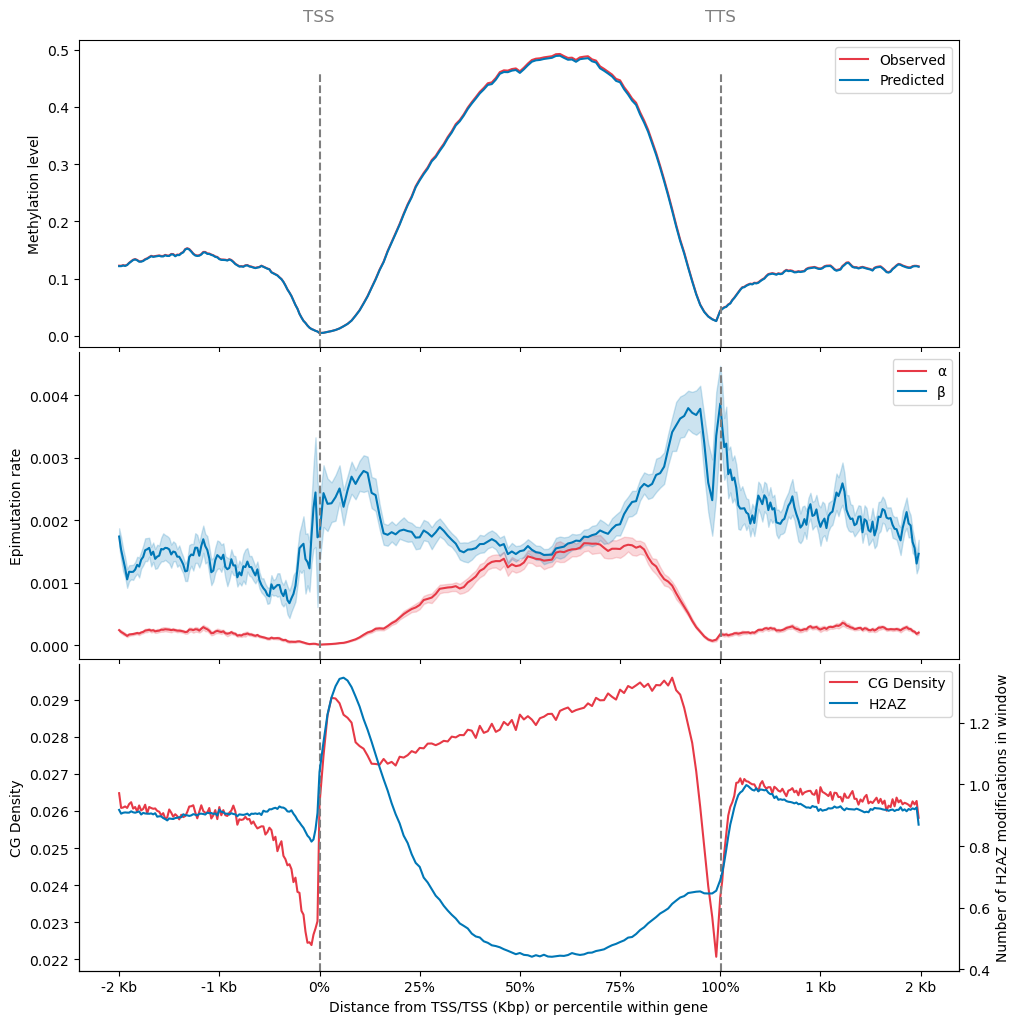

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1 ,sharex=True, figsize=(10,10)) 
ax4 = ax3.twinx() # instantiate a second axes that shares the same x-axis for H2AZ

r = "#e63946"
b = "#0077b6"
ax1.plot(x, obs, r, x, pred, b)
ax2.plot(x, alpha, r, x, beta, b)
ax2.fill_between(x, alpha_ci_lower, alpha_ci_upper, color=r, alpha=0.2)
ax2.fill_between(x, beta_ci_lower, beta_ci_upper, color=b, alpha=0.2)
c, = ax3.plot(x, cg_density, r, label='CG Density')
h, = ax4.plot(x, h2az, b, label='H2AZ')

def format_tick(x, pos): 
    if x < 0: 
        return f'{(x //250):.0f} Kb'
    elif x <= 1000:
        return f'{(x/10):.0f}%'
    else:
        return f'{((x -1000) // 250):.0f} Kb'
    
ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
ax1.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
ax1.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
ax1.annotate("TSS", xy=(0,0), xytext=(-40, 0.55),  color='C7', fontsize=12)
ax1.annotate("TTS", xy=(100,0), xytext=(962, 0.55),  color='C7', fontsize=12)
ax1.legend(['Observed', 'Predicted'], loc='upper right')
ax1.set_ylabel('Methylation level')



ax2.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax2.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax2.legend(['α', 'β'], loc='upper right')
ax2.set_ylabel("Epimutation rate")

ax3.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax3.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax3.legend([c,h],['CG Density', "H2AZ"], loc='upper right')
ax3.set_ylabel("CG Density")
ax3.set_xlabel('Distance from TSS/TSS (Kbp) or percentile within gene')
ax4.set_ylabel("Number of H2AZ modifications in window")


fig.tight_layout(pad=0)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines["top"].set_visible(False)



plt.savefig("3.png", dpi=120, bbox_inches="tight", pad_inches = 1)
plt.show()



## Fig. S1

- Comparison of wt, cmt3 and suv 

- Observed
- Alpha
- Beta

First, we need to calculate the statistical significance of the difference between each genotype for both alpha and beta. This is done by the compair function based on a t-test

In [8]:
from scipy import stats

# Samples a & b are lists of observables like alpha or beta, n is the number of samples in the pedigree
def compair(a,b, std_a, std_b,  n_a, n_b):
    
    t = (a-b) / np.sqrt( (std_a**2 + std_b**2)  )
    df = ((std_a**2 + std_b**2)**2) / ( (std_a**4 / (n_a-1)) + (std_b**4 / (n_b-1)) )
    p = stats.t.sf(np.abs(t), df)
    return p


In [9]:
wt_alphas = alpha
cmt3_alphas = cmt3[:, cmt3_headers.index("alpha")]
suv_alphas = suv[:, suv_headers.index("alpha")]

wt_betas = beta
cmt3_betas = cmt3[:,cmt3_headers.index("beta")]
suv_betas = suv[:,suv_headers.index("beta")]

wt_alpha_std = wt_new[:,wt_new_headers.index("sd_alpha")]
cmt3_alpha_std = cmt3[:,cmt3_headers.index("sd_alpha")]
suv_alpha_std = suv[:,suv_headers.index("sd_alpha")]

wt_beta_std = wt_new[:,wt_new_headers.index("sd_beta")]
cmt3_beta_std = cmt3[:,cmt3_headers.index("sd_beta")]
suv_beta_std = suv[:,suv_headers.index("sd_beta")]

def N(n):
    N = (n-1) * n/2
    return N

p_values = np.zeros((wt_alphas.shape[0], 6))

# Iterate over all windows
for w in range(0, wt_alphas.shape[0]):

    n_wt = 13
    n_cmt3 = 7
    n_suv = 15

    N_wt = N(n_wt)
    N_cmt3 = N(n_cmt3)
    N_suv = N(n_suv)

    # Calculate p-values for alpha and beta
    p_alpha_wt_cmt3 = compair(wt_alphas[w], cmt3_alphas[w], wt_alpha_std[w], cmt3_alpha_std[w], N_wt, N_cmt3)
    p_beta_wt_cmt3 = compair(wt_betas[w], cmt3_betas[w], wt_beta_std[w], cmt3_beta_std[w], N_wt, N_cmt3)

    p_alpha_wt_suv = compair(wt_alphas[w], suv_alphas[w], wt_alpha_std[w], suv_alpha_std[w], N_wt, N_suv)
    p_beta_wt_suv = compair(wt_betas[w], suv_betas[w], wt_beta_std[w], suv_beta_std[w], N_wt, N_suv)

    p_alpha_cmt3_suv = compair(cmt3_alphas[w], suv_alphas[w], cmt3_alpha_std[w], suv_alpha_std[w], N_cmt3, N_suv)
    p_beta_cmt3_suv = compair(cmt3_betas[w], suv_betas[w], cmt3_beta_std[w], suv_beta_std[w], N_cmt3, N_suv)

    # Print the results in CSV format
    p_values[w] = [p_alpha_wt_cmt3, p_beta_wt_cmt3, p_alpha_wt_suv, p_beta_wt_suv, p_alpha_cmt3_suv, p_beta_cmt3_suv]


significant = lambda x :   x < 0.05

significant_windows = significant(p_values)


    

/tmp/ipykernel_5236/518395233.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])
/tmp/ipykernel_5236/518395233.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])


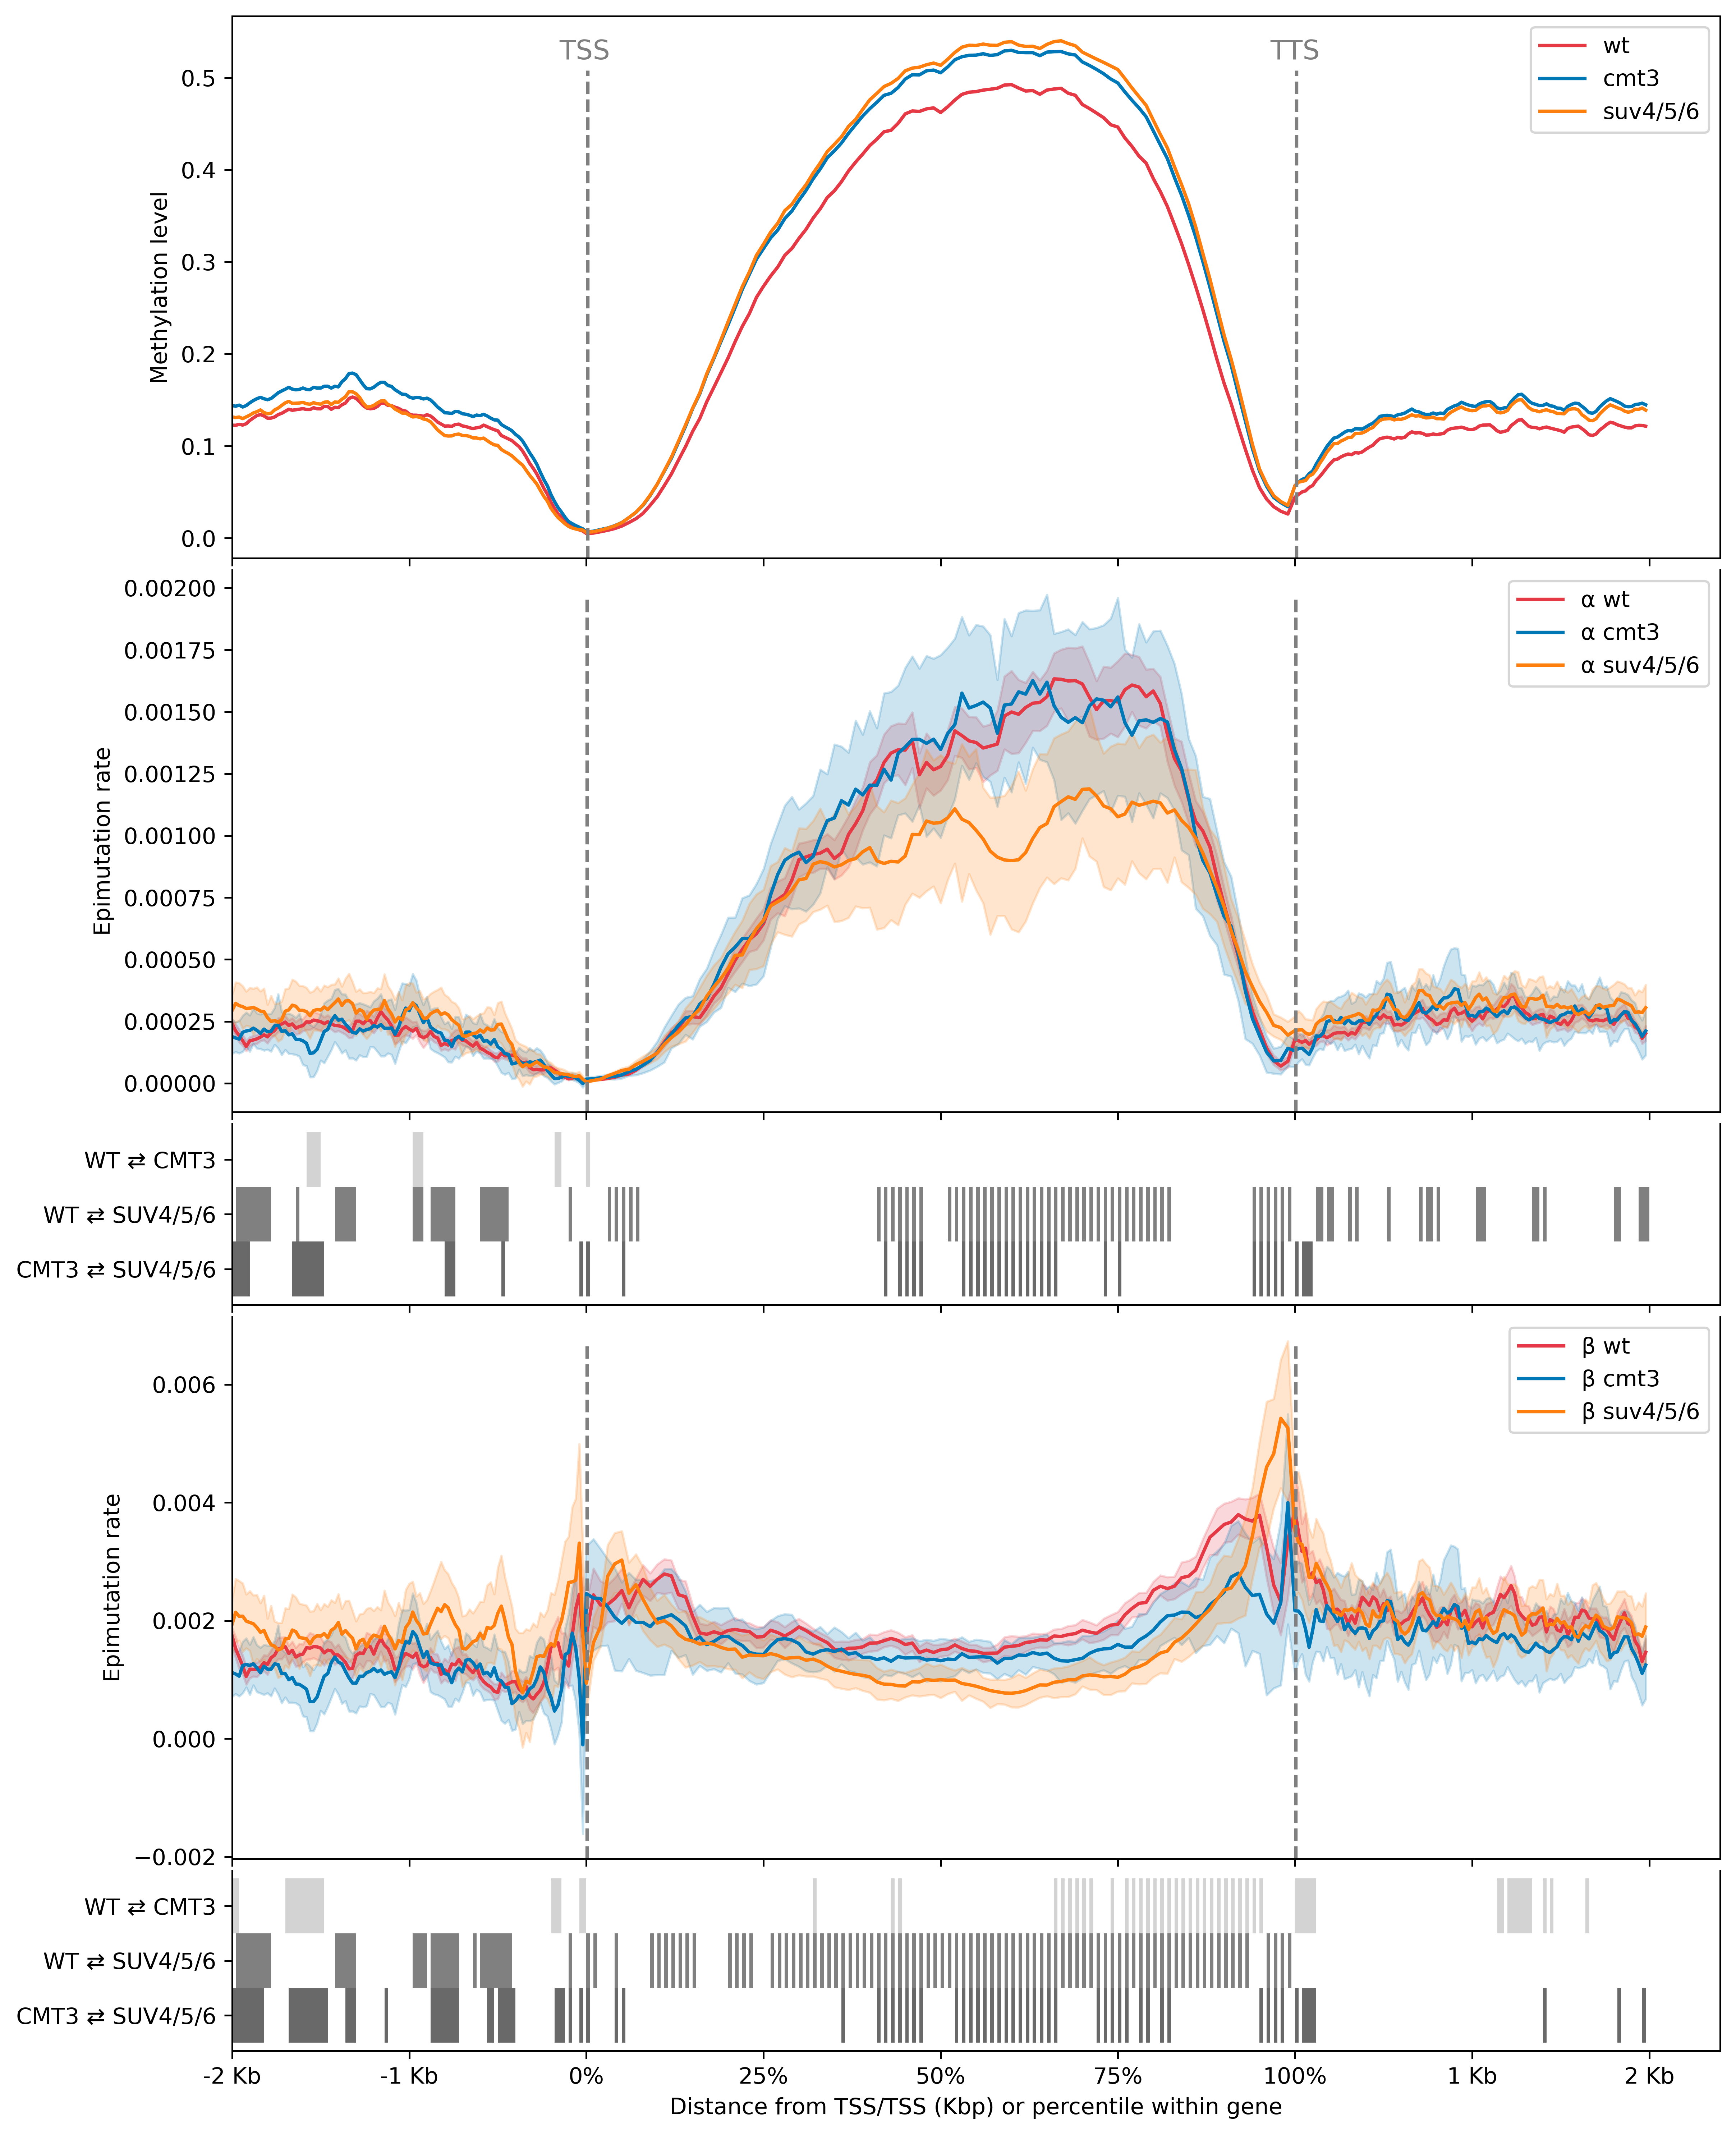

In [10]:
dpi = 450
fig, (ax1, ax2, ax3,ax4, ax5) = plt.subplots(5,1 ,sharex=True, figsize=(10,13) ,gridspec_kw={'height_ratios': [3,3, 1,3,1]}, dpi=dpi) 



r = "#e63946"
b = "#0077b6"
o = "C1"

wt_obs = wt_new[:, wt_new_headers.index('obs_steady_state')]
cmt_obs = cmt3[:, cmt3_headers.index('obs_steady_state')]
suv_obs = suv[:, suv_headers.index('obs_steady_state')]

cmt_alpha = cmt3[:, cmt3_headers.index('alpha')]
cmt_beta = cmt3[:, cmt3_headers.index('beta')]
cmt_alpha_ci_lower = cmt3[:, cmt3_headers.index("ci_alpha_0.025")]
cmt_alpha_ci_upper = cmt3[:, cmt3_headers.index("ci_alpha_0.975")]
cmt_beta_ci_lower = cmt3[:, cmt3_headers.index("ci_beta_0.025")]
cmt_beta_ci_upper = cmt3[:, cmt3_headers.index("ci_beta_0.975")]

suv_alpha = suv[:, suv_headers.index('alpha')]
suv_beta = suv[:, suv_headers.index('beta')]
suv_alpha_ci_lower = suv[:, suv_headers.index("ci_alpha_0.025")]
suv_alpha_ci_upper = suv[:, suv_headers.index("ci_alpha_0.975")]
suv_beta_ci_lower = suv[:, suv_headers.index("ci_beta_0.025")]
suv_beta_ci_upper = suv[:, suv_headers.index("ci_beta_0.975")]


def format_tick(x, pos): 
    if x < 0: 
        return f'{(x //250):.0f} Kb'
    elif x <= 1000:
        return f'{(x/10):.0f}%'
    else:
        return f'{((x -1000) // 250):.0f} Kb'
ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
    
ax1.plot(x, wt_obs, r, x, cmt_obs, b, x, suv_obs, o)
ax1.axvline(x=2,ymax=0.9, color='C7', linestyle='--')
ax1.axvline(x=1002, ymax=0.9,color='C7', linestyle='--')
ax1.annotate("TSS", xy=(0,0), xytext=(-38, 0.52),  color='C7', fontsize=12)
ax1.annotate("TTS", xy=(100,0), xytext=(965, 0.52),  color='C7', fontsize=12)
ax1.legend(['wt', 'cmt3', "suv4/5/6"], loc='upper right')
ax1.set_ylabel('Methylation level')

# Pick every second entry, then reverse the order (the barplot is kinda upside down)
significant_alphas = significant_windows[:, 0::2][:, ::-1]
significant_betas = significant_windows[:, 1::2][:, ::-1]

ax2.plot(x, alpha, r, x, cmt_alpha, b, x, suv_alpha, o)
ax2.fill_between(x, alpha_ci_lower, alpha_ci_upper, color=r, alpha=0.2)
ax2.fill_between(x, cmt_alpha_ci_lower, cmt_alpha_ci_upper, color=b, alpha=0.2)
ax2.fill_between(x, suv_alpha_ci_lower, suv_alpha_ci_upper, color=o, alpha=0.2)
ax2.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax2.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax2.legend(['α wt', 'α cmt3' , "α suv4/5/6"], loc='upper right')
ax2.set_ylabel("Epimutation rate")

label = [0,.05,.1]
colors = ["dimgray", "gray", "lightgray"]
for w in range(significant_windows.shape[0]):
    left = 0 
    if w < 100:
        left = w * 5 -500
    if w >= 100 and w < 200:
        left = (w-100) * 10
    if w >= 200:
        left = (w-200) * 5 + 1000

    
    ax3.barh(label, significant_alphas[w]*5,  color=colors, left=left, height=.05, )

ax4.plot(x, beta, r, x, cmt_beta, b, x, suv_beta, o)
ax4.fill_between(x, beta_ci_lower, beta_ci_upper, color=r, alpha=0.2)
ax4.fill_between(x, cmt_beta_ci_lower, cmt_beta_ci_upper, color=b, alpha=0.2)
ax4.fill_between(x, suv_beta_ci_lower, suv_beta_ci_upper, color=o, alpha=0.2)

ax4.axvline(x=1,ymax=0.95, color='C7', linestyle='--')
ax4.axvline(x=1001, ymax=0.95,color='C7', linestyle='--')
ax4.legend(['β wt', "β cmt3", "β suv4/5/6"], loc='upper right')
ax4.set_ylabel("Epimutation rate")
ax5.set_xlabel('Distance from TSS/TSS (Kbp) or percentile within gene')


for w in range(significant_windows.shape[0]):
    left = 0 
    if w < 100:
        left = w * 5 -500
    if w >= 100 and w < 200:
        left = (w-100) * 10
    if w >= 200:
        left = (w-200) * 5 + 1000

    
    ax5.barh(label, significant_betas[w]*5,  color=colors, left=left, height=.05)


fig.tight_layout(pad=0)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax3.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])
ax3.yaxis.set_ticks([0.0, 0.05, 0.1])


ax5.yaxis.set_ticklabels(["CMT3 ⇄ SUV4/5/6", "WT ⇄ SUV4/5/6","WT ⇄ CMT3" ])
ax5.yaxis.set_ticks([0.0, 0.05, 0.1])

plt.savefig("4.png",  bbox_inches="tight", pad_inches = 1)
plt.show()



Figure 3 right

- $\alpha$ vs CG Density
- $\alpha$ vs H2AZ

Show dotplot and lowess line

# Multiple Regression 

Estimate a model of alpha + beta from Chromatine States

Tutorial taken from: https://scipy-lectures.org/packages/statistics/auto_examples/plot_regression_3d.html

In [11]:
multiple_regression_results = {
    "chr_states_alpha": 0,
    "histone_mods_alpha": 0,
    "combined_alpha": 0,
    "chr_states_intragenic_alpha": 0,
    "histone_mods_intragenic_alpha": 0,
    "combined_intragenic_alpha": 0,
    "chr_states_beta": 0,
    "histone_mods_beta": 0,
    "combined_beta": 0,   
    "chr_states_intragenic_beta": 0,
    "histone_mods_intragenic_beta": 0,
    "combined_intragenic_beta":0
}

In [12]:
import polars as pl
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

data = cs_gbM.hstack(hist_mods_gbM)

data = data.with_columns(alpha=alpha)
data = data.with_columns(beta=beta)

alpha_formula = "alpha ~ " + " + ".join([s for s in data.columns if s != "alpha" and s != "beta" and "S" in s])
beta_formula = "beta ~ " + " + ".join([s for s in data.columns if s != "alpha" and s != "beta" and "S" in s])
alpha_model = ols(alpha_formula, data).fit()
beta_model = ols(beta_formula, data).fit()

print(alpha_model.summary())
print(beta_model.summary())

multiple_regression_results["chr_states_alpha"] = alpha_model.rsquared_adj
multiple_regression_results["chr_states_beta"] = beta_model.rsquared_adj

anova_results_alpha = anova_lm(alpha_model)
anova_results_beta = anova_lm(beta_model)

print("Alpha ANOVA")
print(anova_results_alpha)
print("Beta ANOVA")
print(anova_results_beta)


                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     502.9
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          2.23e-221
Time:                        20:50:10   Log-Likelihood:                 2512.2
No. Observations:                 300   AIC:                            -4950.
Df Residuals:                     263   BIC:                            -4813.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007   8.07e-05      8.263      0.0

Repeat multiple regression for intragenic data only

In [13]:
intragenic_data = data[100:200]
display(intragenic_data)

alpha_formula = "alpha ~ " + " + ".join([s for s in intragenic_data.columns if s != "alpha" and s != "beta" and "S" in s])
beta_formula = "beta ~ " + " + ".join([s for s in intragenic_data.columns if s != "alpha" and s != "beta" and "S" in s])

print(alpha_formula)
print(beta_formula)

alpha_intragenic_model = ols(alpha_formula, intragenic_data).fit()
beta_intragenic_model = ols(beta_formula, intragenic_data).fit()

print(alpha_intragenic_model.summary())
print(beta_intragenic_model.summary())

multiple_regression_results["chr_states_intragenic_alpha"] = alpha_intragenic_model.rsquared_adj
multiple_regression_results["chr_states_intragenic_beta"] = beta_intragenic_model.rsquared_adj

anova_results_intragenic_alpha = anova_lm(alpha_intragenic_model)
anova_results_intragenic_beta = anova_lm(beta_intragenic_model)

print("Alpha ANOVA")
print(anova_results_intragenic_alpha)
print("Beta ANOVA")
print(anova_results_intragenic_beta)

shape: (100, 45)
┌───────┬──────┬─────┬──────┬───┬──────────┬──────────┬──────────┬──────────┐
│ S01   ┆ S02  ┆ S03 ┆ S04  ┆ … ┆ H3K36Me3 ┆ H3K56Ac  ┆ alpha    ┆ beta     │
│ ---   ┆ ---  ┆ --- ┆ ---  ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f32   ┆ f32  ┆ f32 ┆ f32  ┆   ┆ f32      ┆ f32      ┆ f32      ┆ f32      │
╞═══════╪══════╪═════╪══════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 3.0   ┆ 4.0  ┆ 0.0 ┆ 1.0  ┆ … ┆ 71749.0  ┆ 93678.0  ┆ 0.000009 ┆ 0.00176  │
│ 4.0   ┆ 4.0  ┆ 0.0 ┆ 1.0  ┆ … ┆ 80081.0  ┆ 99749.0  ┆ 0.000014 ┆ 0.002435 │
│ 5.0   ┆ 5.0  ┆ 0.0 ┆ 1.0  ┆ … ┆ 86848.0  ┆ 104987.0 ┆ 0.000016 ┆ 0.002264 │
│ 7.0   ┆ 3.0  ┆ 0.0 ┆ 0.0  ┆ … ┆ 93199.0  ┆ 108574.0 ┆ 0.000019 ┆ 0.002272 │
│ …     ┆ …    ┆ …   ┆ …    ┆ … ┆ …        ┆ …        ┆ …        ┆ …        │
│ 266.0 ┆ 30.0 ┆ 5.0 ┆ 19.0 ┆ … ┆ 24181.0  ┆ 42753.0  ┆ 0.000142 ┆ 0.003243 │
│ 298.0 ┆ 34.0 ┆ 6.0 ┆ 13.0 ┆ … ┆ 23866.0  ┆ 42788.0  ┆ 0.000091 ┆ 0.002602 │
│ 272.0 ┆ 11.0 ┆ 4.0 ┆ 8.0  ┆ … ┆ 24239.0  ┆ 42506.0  ┆ 0.000069 ┆ 0.002322 │
│ 192.0 ┆ 17.0 ┆ 3.0 ┆ 6.0  ┆ … ┆ 24435.0  ┆ 42518.0  ┆ 0.000089 ┆ 0.003355 │
└───────┴──────┴─────┴──────┴───┴──────────┴──────────┴──────────┴──────────┘

alpha ~ S01 + S02 + S03 + S04 + S05 + S06 + S07 + S08 + S09 + S10 + S11 + S12 + S13 + S14 + S15 + S16 + S17 + S18 + S19 + S20 + S21 + S22 + S23 + S24 + S25 + S26 + S27 + S28 + S29 + S30 + S31 + S32 + S33 + S34 + S35 + S36
beta ~ S01 + S02 + S03 + S04 + S05 + S06 + S07 + S08 + S09 + S10 + S11 + S12 + S13 + S14 + S15 + S16 + S17 + S18 + S19 + S20 + S21 + S22 + S23 + S24 + S25 + S26 + S27 + S28 + S29 + S30 + S31 + S32 + S33 + S34 + S35 + S36
                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     269.7
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           7.03e-59
Time:                        20:50:10   Log-Likelihood:                 853.39
No. Observations:                 100   AIC:                            -1639.
Df R

## Histone Modifications
Same analysis for histone mods only

In [14]:
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm


alpha_formula = "alpha ~ " + " + ".join([s for s in data.columns if s != "alpha" and s != "beta" and "S" not in s])
beta_formula = "beta ~ " + " + ".join([s for s in data.columns if s != "alpha" and s != "beta" and "S" not in s])
print(alpha_formula)
print(beta_formula)
alpha_model = ols(alpha_formula, data).fit()
beta_model = ols(beta_formula, data).fit()

print(alpha_model.summary())
print(beta_model.summary())

multiple_regression_results["histone_mods_alpha"] = alpha_model.rsquared_adj
multiple_regression_results["histone_mods_beta"] = beta_model.rsquared_adj

anova_results_alpha = anova_lm(alpha_model)
anova_results_beta = anova_lm(beta_model)

print("Alpha ANOVA")
print(anova_results_alpha)
print("Beta ANOVA")
print(anova_results_beta)


alpha ~ H2AZ + H3 + H3K4Me1 + H3K4Me3 + H3K27Me3 + H3K36Me3 + H3K56Ac
beta ~ H2AZ + H3 + H3K4Me1 + H3K4Me3 + H3K27Me3 + H3K36Me3 + H3K56Ac
                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     580.2
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          3.19e-167
Time:                        20:50:10   Log-Likelihood:                 2280.5
No. Observations:                 300   AIC:                            -4545.
Df Residuals:                     292   BIC:                            -4515.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

Histone Mods Intragenic only

In [15]:
intragenic_data = data[100:200]

alpha_formula = "alpha ~ " + " + ".join([s for s in intragenic_data.columns if s != "alpha" and s != "beta" and "S" not in s])
beta_formula = "beta ~ " + " + ".join([s for s in intragenic_data.columns if s != "alpha" and s != "beta" and "S" not in s])
print(alpha_formula)
print(beta_formula)

alpha_intragenic_model = ols(alpha_formula, intragenic_data).fit()
beta_intragenic_model = ols(beta_formula, intragenic_data).fit()

print(alpha_intragenic_model.summary())
print(beta_intragenic_model.summary())

multiple_regression_results["histone_mods_intragenic_alpha"] = alpha_intragenic_model.rsquared_adj
multiple_regression_results["histone_mods_intragenic_beta"] = beta_intragenic_model.rsquared_adj

anova_results_intragenic_alpha = anova_lm(alpha_intragenic_model)
anova_results_intragenic_beta = anova_lm(beta_intragenic_model)

print("Alpha ANOVA")
print(anova_results_intragenic_alpha)
print("Beta ANOVA")
print(anova_results_intragenic_beta)

alpha ~ H2AZ + H3 + H3K4Me1 + H3K4Me3 + H3K27Me3 + H3K36Me3 + H3K56Ac
beta ~ H2AZ + H3 + H3K4Me1 + H3K4Me3 + H3K27Me3 + H3K36Me3 + H3K56Ac
                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     581.2
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           3.20e-73
Time:                        20:50:10   Log-Likelihood:                 798.40
No. Observations:                 100   AIC:                            -1581.
Df Residuals:                      92   BIC:                            -1560.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

# Combined Chromatine States and Histone Mods model

In [16]:
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

alpha_formula = "alpha ~ " + " + ".join([s for s in data.columns if s != "alpha" and s != "beta"])
beta_formula = "beta ~ " + " + ".join([s for s in data.columns if s != "alpha" and s != "beta"])
print(alpha_formula)
print(beta_formula)
alpha_model = ols(alpha_formula, data).fit()
beta_model = ols(beta_formula, data).fit()


print(alpha_model.summary())
print(beta_model.summary())

multiple_regression_results["combined_alpha"] = alpha_model.rsquared_adj
multiple_regression_results["combined_beta"] = beta_model.rsquared_adj

anova_results_alpha = anova_lm(alpha_model)
anova_results_beta = anova_lm(beta_model)



print("Alpha ANOVA")
print(anova_results_alpha)
print("Beta ANOVA")
print(anova_results_beta)


alpha ~ S01 + S02 + S03 + S04 + S05 + S06 + S07 + S08 + S09 + S10 + S11 + S12 + S13 + S14 + S15 + S16 + S17 + S18 + S19 + S20 + S21 + S22 + S23 + S24 + S25 + S26 + S27 + S28 + S29 + S30 + S31 + S32 + S33 + S34 + S35 + S36 + H2AZ + H3 + H3K4Me1 + H3K4Me3 + H3K27Me3 + H3K36Me3 + H3K56Ac
beta ~ S01 + S02 + S03 + S04 + S05 + S06 + S07 + S08 + S09 + S10 + S11 + S12 + S13 + S14 + S15 + S16 + S17 + S18 + S19 + S20 + S21 + S22 + S23 + S24 + S25 + S26 + S27 + S28 + S29 + S30 + S31 + S32 + S33 + S34 + S35 + S36 + H2AZ + H3 + H3K4Me1 + H3K4Me3 + H3K27Me3 + H3K36Me3 + H3K56Ac
                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     942.6
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          8.19e-258
Time:                        20:50

# Backward and Forward Feature Selection, Intragenic, gbM

In [17]:
from statsmodels.formula.api import ols
from sklearn.feature_selection import SequentialFeatureSelector, r_regression, f_regression
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
intragenic = data[100:200]
intragenic_cg_density = cg_density[100:200] 
reg = LinearRegression()
y = intragenic["alpha"]
w = intragenic["beta"]
X  = intragenic.drop(columns=["alpha", "beta", "Input"])
X = X.with_columns(cg_density = intragenic_cg_density)
display(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
_, _ , w_train, w_test = train_test_split(X, w, test_size=0.5, random_state=42)

r2_alpha_all_features = reg.fit(X_train, y_train).score(X_test, y_test)
print(r2_alpha_all_features)
r2_beta_all_features = reg.fit(X_train, w_train).score(X_test, w_test)
print(r2_beta_all_features)

alpha_top_five = ""
alpha_top_five_coeff = []

res_alpha = np.zeros(X.shape[1]-1)
for i in range(1, X.shape[1]):
    
    sfs_forward = SequentialFeatureSelector(LinearRegression(),  n_features_to_select=i, direction='backward', n_jobs=-1)
    
    model_forward = sfs_forward.fit(X_train, y_train)
    r_squared = reg.fit(sfs_forward.transform(X_train), y_train).score(sfs_forward.transform(X_test), y_test)
    print(i, r_squared, model_forward.get_feature_names_out())
    res_alpha[i-1] = r_squared

    if i == 5:
        alpha_top_five = model_forward.get_feature_names_out()
        alpha_top_five_coeff = reg.fit(sfs_forward.transform(X), y).coef_


beta_top_five = ""
beta_top_five_coeff = []

res_beta = np.zeros(X.shape[1]-1)
for i in range(1, X.shape[1]):
    sfs_forward = SequentialFeatureSelector(LinearRegression(),  n_features_to_select=i, direction='backward', n_jobs=-1)
    model_forward = sfs_forward.fit(X_train, w_train)
    r_squared = reg.fit(sfs_forward.transform(X_train), w_train).score(sfs_forward.transform(X_test), w_test)
    print(i, r_squared, model_forward.get_feature_names_out())
    res_beta[i-1] = r_squared

    if i == 5:
        beta_top_five = model_forward.get_feature_names_out()
        beta_top_five_coeff = reg.fit(sfs_forward.transform(X), w).coef_


print(alpha_top_five, alpha_top_five_coeff, beta_top_five, beta_top_five_coeff)


shape: (100, 44)
┌───────┬──────┬─────┬──────┬───┬──────────┬──────────┬──────────┬────────────┐
│ S01   ┆ S02  ┆ S03 ┆ S04  ┆ … ┆ H3K27Me3 ┆ H3K36Me3 ┆ H3K56Ac  ┆ cg_density │
│ ---   ┆ ---  ┆ --- ┆ ---  ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---        │
│ f32   ┆ f32  ┆ f32 ┆ f32  ┆   ┆ f32      ┆ f32      ┆ f32      ┆ f64        │
╞═══════╪══════╪═════╪══════╪═══╪══════════╪══════════╪══════════╪════════════╡
│ 3.0   ┆ 4.0  ┆ 0.0 ┆ 1.0  ┆ … ┆ 8974.0   ┆ 71749.0  ┆ 93678.0  ┆ 0.02618    │
│ 4.0   ┆ 4.0  ┆ 0.0 ┆ 1.0  ┆ … ┆ 9536.0   ┆ 80081.0  ┆ 99749.0  ┆ 0.027488   │
│ 5.0   ┆ 5.0  ┆ 0.0 ┆ 1.0  ┆ … ┆ 10189.0  ┆ 86848.0  ┆ 104987.0 ┆ 0.028579   │
│ 7.0   ┆ 3.0  ┆ 0.0 ┆ 0.0  ┆ … ┆ 11116.0  ┆ 93199.0  ┆ 108574.0 ┆ 0.029047   │
│ …     ┆ …    ┆ …   ┆ …    ┆ … ┆ …        ┆ …        ┆ …        ┆ …          │
│ 266.0 ┆ 30.0 ┆ 5.0 ┆ 19.0 ┆ … ┆ 14965.0  ┆ 24181.0  ┆ 42753.0  ┆ 0.025046   │
│ 298.0 ┆ 34.0 ┆ 6.0 ┆ 13.0 ┆ … ┆ 14356.0  ┆ 23866.0  ┆ 42788.0  ┆ 0.023973   │
│ 272.0 ┆ 11.0 ┆ 4.0 ┆ 8.0  ┆ … ┆ 13777.0  ┆ 24239.0  ┆ 42506.0  ┆ 0.023146   │
│ 192.0 ┆ 17.0 ┆ 3.0 ┆ 6.0  ┆ … ┆ 13259.0  ┆ 24435.0  ┆ 42518.0  ┆ 0.022072   │
└───────┴──────┴─────┴──────┴───┴──────────┴──────────┴──────────┴────────────┘

0.934611210475676
0.8035574944926301
1 0.7557061235854529 ['H2AZ']


2 0.8754009720162214 ['S21' 'H2AZ']
3 0.879329785864041 ['S02' 'S21' 'H2AZ']
4 0.91907483947 ['S02' 'S21' 'H2AZ' 'H3K4Me1']
5 0.965309821089179 ['S02' 'S21' 'S23' 'H2AZ' 'H3K4Me1']
6 0.9808948125935228 ['S02' 'S09' 'S21' 'S23' 'H2AZ' 'H3K4Me1']
7 0.9845497209546873 ['S01' 'S02' 'S09' 'S21' 'S23' 'H2AZ' 'H3K4Me1']
8 0.9841807739693529 ['S01' 'S02' 'S09' 'S20' 'S21' 'S23' 'H2AZ' 'H3K4Me1']
9 0.9812272804093725 ['S01' 'S02' 'S09' 'S15' 'S20' 'S21' 'S23' 'H2AZ' 'H3K4Me1']
10 0.9839862416671175 ['S01' 'S02' 'S03' 'S09' 'S15' 'S20' 'S21' 'S23' 'H2AZ' 'H3K4Me1']
11 0.9832091800160505 ['S01' 'S02' 'S03' 'S05' 'S09' 'S15' 'S20' 'S21' 'S23' 'H2AZ' 'H3K4Me1']
12 0.9855430510638011 ['S01' 'S02' 'S03' 'S05' 'S09' 'S15' 'S20' 'S21' 'S23' 'H2AZ' 'H3K4Me1'
 'H3K27Me3']
13 0.9856246429231521 ['S01' 'S02' 'S03' 'S05' 'S09' 'S15' 'S20' 'S21' 'S23' 'S28' 'H2AZ'
 'H3K4Me1' 'H3K27Me3']
14 0.988110701917801 ['S01' 'S02' 'S03' 'S05' 'S09' 'S15' 'S20' 'S21' 'S23' 'S25' 'S28' 'H2AZ'
 'H3K4Me1' 'H3K27Me3']
15 0.

(1.0, 44.0)

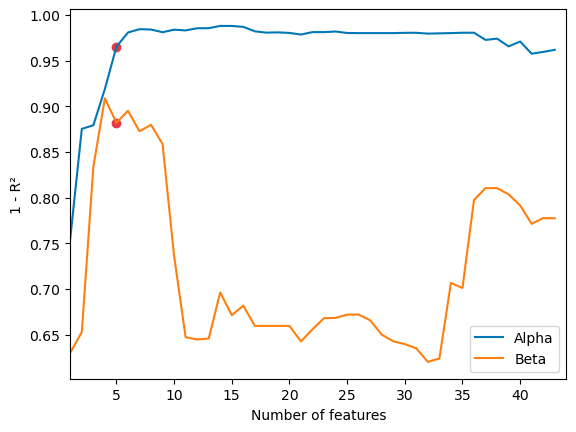

In [18]:

xx = np.arange(1,len(res_alpha )+1)
plt.plot(xx, res_alpha, color=b)
plt.plot(xx, res_beta, color=o)
plt.legend(["Alpha", "Beta"])
plt.xlabel("Number of features")
plt.ylabel("1 - R²")
ax = plt.gca()
# ax.axhline(y=r2_alpha_all_features, color=b, linestyle='--')
# ax.axhline(y=r2_beta_all_features, color=o, linestyle='--')
# ['S02' 'S29' 'H3K4me3'] bei alpha
# ['H3K4me3' 'H3K56ac' 'Input'] bei beta
# add single red point at (7, res_alpha[6])
plt.scatter(5, res_alpha[4], color=r)
plt.scatter(5, res_beta[4], color=r)
# set x range from 1 to len(res_alpha) +1
plt.xlim(1, len(res_alpha)+1)

# make y axis log
# plt.yscale('log')


Koeffizienten der 5 wichtigsten Features

In [19]:
important_X_alpha = X[['S13', 'S32', 'H3K36Me3', 'H3K56Ac', 'cg_density']]
important_X_beta = X[['S32', 'H2AZ', 'H3K4Me1', 'H3K4Me3', 'cg_density']]

reg = LinearRegression()
alpha_coeff = reg.fit(important_X_alpha, y).coef_
beta_coeff = reg.fit(important_X_beta, w).coef_

print(alpha_coeff)
print(beta_coeff)

[ 1.86043534e-05 -1.45975983e-04  3.81792107e-09 -1.84346129e-08
  2.01546048e-01]
[-6.27572365e-05  1.20893842e-07  2.97762032e-08 -7.55865715e-08
 -4.35064811e-02]


Intragenic

In [20]:
intragenic_data = data[100:200]

alpha_formula = "alpha ~ " + " + ".join([s for s in intragenic_data.columns if s != "alpha" and s != "beta"])
beta_formula = "beta ~ " + " + ".join([s for s in intragenic_data.columns if s != "alpha" and s != "beta"])

alpha_intragenic_model = ols(alpha_formula, intragenic_data).fit()
beta_intragenic_model = ols(beta_formula, intragenic_data).fit()

print(alpha_intragenic_model.summary())
print(beta_intragenic_model.summary())

multiple_regression_results["combined_intragenic_alpha"] = alpha_intragenic_model.rsquared_adj
multiple_regression_results["combined_intragenic_beta"] = beta_intragenic_model.rsquared_adj

anova_results_intragenic_alpha = anova_lm(alpha_intragenic_model)
anova_results_intragenic_beta = anova_lm(beta_intragenic_model)

print("Alpha ANOVA")
print(anova_results_intragenic_alpha)
print("Beta ANOVA")
print(anova_results_intragenic_beta)

                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     264.0
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           3.95e-54
Time:                        20:53:42   Log-Likelihood:                 867.46
No. Observations:                 100   AIC:                            -1653.
Df Residuals:                      59   BIC:                            -1546.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0023      0.002      1.230      0.2

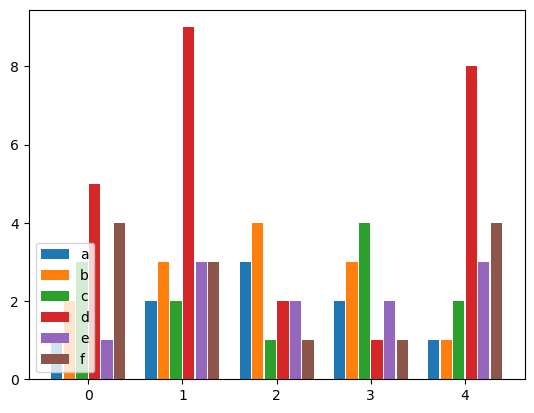

In [21]:
# copied from https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), loc="lower left")


if __name__ == "__main__":
    # Usage example:
    data_ = {
        "a": [1, 2, 3, 2, 1],
        "b": [2, 3, 4, 3, 1],
        "c": [3, 2, 1, 4, 2],
        "d": [5, 9, 2, 1, 8],
        "e": [1, 3, 2, 2, 3],
        "f": [4, 3, 1, 1, 4],
    }

    fig, ax = plt.subplots()
    bar_plot(ax, data_, total_width=.8, single_width=.9)
    plt.show()


{'chr_states_alpha': 0.9837217140173, 'histone_mods_alpha': 0.9313187781251608, 'combined_alpha': 0.9926695066026396, 'chr_states_intragenic_alpha': 0.9889566844337054, 'histone_mods_intragenic_alpha': 0.9762051795627179, 'combined_intragenic_alpha': 0.9906765108259301, 'chr_states_beta': 0.7406042898103877, 'histone_mods_beta': 0.5550947227130609, 'combined_beta': 0.799671926191521, 'chr_states_intragenic_beta': 0.942074343141557, 'histone_mods_intragenic_beta': 0.9208780918107895, 'combined_intragenic_beta': 0.9485260605503372}
{'Chromatin States': [0.9837217140173, 0.9889566844337054, 0.7406042898103877, 0.942074343141557], 'Histone Modifications': [0.9313187781251608, 0.9762051795627179, 0.5550947227130609, 0.9208780918107895], 'Combined': [0.9926695066026396, 0.9906765108259301, 0.799671926191521, 0.9485260605503372]}


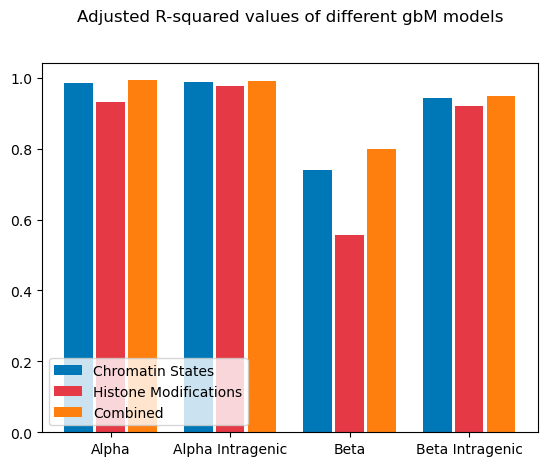

In [22]:
# Plot the r_squared values of different models
print(multiple_regression_results)

import matplotlib.pyplot as plt
import numpy as np

alpha_all = list(multiple_regression_results.items())[0:3]
alpha_intragenic = list(multiple_regression_results.items())[3:6]
beta_all = list(multiple_regression_results.items())[6:9]
beta_intragenic = list(multiple_regression_results.items())[9:12]

# # bar chart over all keys and values of multiple_regression_results, grouped into groups of three

data_grouped = {
    "Chromatin States": [alpha_all[0][1], alpha_intragenic[0][1], beta_all[0][1], beta_intragenic[0][1]],
    "Histone Modifications": [alpha_all[1][1], alpha_intragenic[1][1], beta_all[1][1], beta_intragenic[1][1]],
    "Combined": [alpha_all[2][1], alpha_intragenic[2][1], beta_all[2][1], beta_intragenic[2][1]]
}
print(data_grouped)
fig, ax = plt.subplots()
bar_plot(ax, data_grouped, total_width=.8, single_width=.9, colors=[b,r,o])
plt.title("Adjusted R-squared values of different gbM models",pad=30)
plt.xticks(range(4), ["Alpha", "Alpha Intragenic", "Beta", "Beta Intragenic"])
plt.show()


# Model for UM Genes

{'Chromatin States': [0.8984676893821322, 0.9356469246558718, 0.9195308119106179, 0.8093795257470047], 'Histone Modifications': [0.8553721931286425, 0.9379367071500532, 0.8921181196613366, 0.7043336871612906], 'Combined': [0.9379901468341736, 0.9489595870958234, 0.9340786298999966, 0.8078084791655895]}


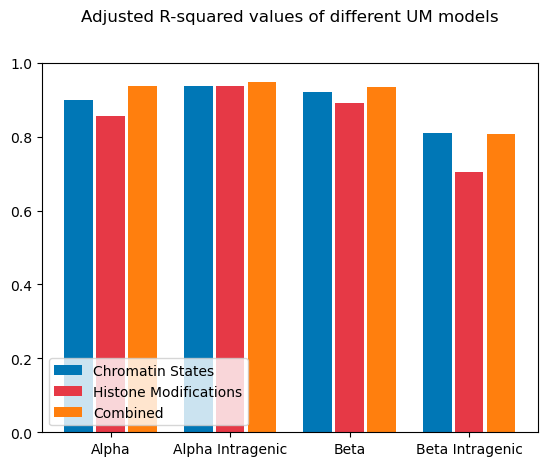

In [23]:
UM_data = cs_UM.hstack(hist_mods_UM)
UM_data = UM_data.with_columns(alpha=UM_alpha)
UM_data = UM_data.with_columns(beta=UM_beta)
UM_data_intragenic = UM_data[100:200]


UM_alpha_formula_cs = "alpha ~ " + " + ".join([s for s in UM_data.columns if s != "alpha" and s != "beta" and "S" in s])
UM_beta_formula_cs = "beta ~ " + " + ".join([s for s in UM_data.columns if s != "alpha" and s != "beta" and "S" in s])
UM_alpha_formula_hist_mods = "alpha ~ " + " + ".join([s for s in UM_data.columns if s != "alpha" and s != "beta" and "S" not in s])
UM_beta_formula_hist_mods = "beta ~ " + " + ".join([s for s in UM_data.columns if s != "alpha" and s != "beta" and "S" not in s])
UM_alpha_formula_combined = "alpha ~ " + " + ".join([s for s in UM_data.columns if s != "alpha" and s != "beta"])
UM_beta_formula_combined = "beta ~ " + " + ".join([s for s in UM_data.columns if s != "alpha" and s != "beta"])

UM_model_alpha_cs = ols(UM_alpha_formula_cs, UM_data).fit()
UM_model_beta_cs = ols(UM_beta_formula_cs, UM_data).fit()
UM_model_alpha_hist_mods = ols(UM_alpha_formula_hist_mods, UM_data).fit()
UM_model_beta_hist_mods = ols(UM_beta_formula_hist_mods, UM_data).fit()
UM_model_alpha_combined = ols(UM_alpha_formula_combined, UM_data).fit()
UM_model_beta_combined = ols(UM_beta_formula_combined, UM_data).fit()

UM_model_alpha_cs_intragenic = ols(UM_alpha_formula_cs, UM_data_intragenic).fit()
UM_model_beta_cs_intragenic = ols(UM_beta_formula_cs, UM_data_intragenic).fit()
UM_model_alpha_hist_mods_intragenic = ols(UM_alpha_formula_hist_mods, UM_data_intragenic).fit()
UM_model_beta_hist_mods_intragenic = ols(UM_beta_formula_hist_mods, UM_data_intragenic).fit()
UM_model_alpha_combined_intragenic = ols(UM_alpha_formula_combined, UM_data_intragenic).fit()
UM_model_beta_combined_intragenic = ols(UM_beta_formula_combined, UM_data_intragenic).fit()

UM_data_grouped = {
    "Chromatin States": [UM_model_alpha_cs.rsquared_adj, UM_model_alpha_cs_intragenic.rsquared_adj, UM_model_beta_cs.rsquared_adj, UM_model_beta_cs_intragenic.rsquared_adj],
    "Histone Modifications": [UM_model_alpha_hist_mods.rsquared_adj, UM_model_alpha_hist_mods_intragenic.rsquared_adj, UM_model_beta_hist_mods.rsquared_adj, UM_model_beta_hist_mods_intragenic.rsquared_adj],
    "Combined": [UM_model_alpha_combined.rsquared_adj, UM_model_alpha_combined_intragenic.rsquared_adj, UM_model_beta_combined.rsquared_adj, UM_model_beta_combined_intragenic.rsquared_adj]
}
print(UM_data_grouped)

fig, ax = plt.subplots()
bar_plot(ax, UM_data_grouped, total_width=.8, single_width=.9, colors=[b,r,o])
plt.title("Adjusted R-squared values of different UM models",pad=30)
plt.xticks(range(4), ["Alpha", "Alpha Intragenic", "Beta", "Beta Intragenic"])
plt.ylim(0,1)
plt.show()



## Feature Selection for UM Genes

In [24]:
from statsmodels.formula.api import ols
from sklearn.feature_selection import SequentialFeatureSelector, r_regression, f_regression
from sklearn.linear_model import  LinearRegression
UM_intragenic = UM_data[100:200]
UM_intragenic_cg_density = UM_cg_counts[100:200]
reg = LinearRegression()
y = UM_intragenic["alpha"]
w = UM_intragenic["beta"]
X  = UM_intragenic.drop(columns=["alpha", "beta", "Input"])
X = X.with_columns(cg_density = UM_intragenic_cg_density)
display(X)

UM_r2_alpha_all_features = reg.fit(X, y).score(X, y)
UM_r2_beta_all_features = reg.fit(X, w).score(X, w)
print(UM_r2_alpha_all_features)
print(UM_r2_beta_all_features)

UM_res_alpha = np.zeros(X.shape[1]-1)
for i in range(1, X.shape[1]):
   
    sfs_forward = SequentialFeatureSelector(LinearRegression(),  n_features_to_select=i, direction='backward')
    model_forward = sfs_forward.fit(X, y)
    selected_features_X = sfs_forward.transform(X)
    r_squared = reg.fit(selected_features_X, y).score(selected_features_X, y)
    print(i, r_squared, model_forward.get_feature_names_out())
    UM_res_alpha[i-1] = r_squared


UM_res_beta = np.zeros(X.shape[1]-1)
for i in range(1, X.shape[1]):
   
    sfs_forward = SequentialFeatureSelector(LinearRegression(),  n_features_to_select=i, direction='backward')
    model_forward = sfs_forward.fit(X, w)
    
    selected_features_X = sfs_forward.transform(X)
    r_squared = reg.fit(selected_features_X, w).score(selected_features_X, w)
    print(i, r_squared, model_forward.get_feature_names_out())
    UM_res_beta[i-1] = r_squared




shape: (100, 44)
┌───────┬──────┬─────┬─────┬───┬──────────┬──────────┬─────────┬────────────┐
│ S01   ┆ S02  ┆ S03 ┆ S04 ┆ … ┆ H3K27Me3 ┆ H3K36Me3 ┆ H3K56Ac ┆ cg_density │
│ ---   ┆ ---  ┆ --- ┆ --- ┆   ┆ ---      ┆ ---      ┆ ---     ┆ ---        │
│ f32   ┆ f32  ┆ f32 ┆ f32 ┆   ┆ f32      ┆ f32      ┆ f32     ┆ f32        │
╞═══════╪══════╪═════╪═════╪═══╪══════════╪══════════╪═════════╪════════════╡
│ 5.0   ┆ 6.0  ┆ 0.0 ┆ 1.0 ┆ … ┆ 26762.0  ┆ 36024.0  ┆ 64974.0 ┆ 23550.0    │
│ 5.0   ┆ 11.0 ┆ 0.0 ┆ 1.0 ┆ … ┆ 26975.0  ┆ 36561.0  ┆ 65961.0 ┆ 25108.0    │
│ 5.0   ┆ 7.0  ┆ 0.0 ┆ 2.0 ┆ … ┆ 27846.0  ┆ 38448.0  ┆ 67567.0 ┆ 26416.0    │
│ 6.0   ┆ 8.0  ┆ 2.0 ┆ 0.0 ┆ … ┆ 28966.0  ┆ 40322.0  ┆ 69888.0 ┆ 27857.0    │
│ …     ┆ …    ┆ …   ┆ …   ┆ … ┆ …        ┆ …        ┆ …       ┆ …          │
│ 89.0  ┆ 20.0 ┆ 2.0 ┆ 3.0 ┆ … ┆ 24826.0  ┆ 25766.0  ┆ 46715.0 ┆ 12375.0    │
│ 98.0  ┆ 12.0 ┆ 4.0 ┆ 4.0 ┆ … ┆ 23995.0  ┆ 25519.0  ┆ 45967.0 ┆ 9368.0     │
│ 100.0 ┆ 5.0  ┆ 1.0 ┆ 2.0 ┆ … ┆ 23544.0  ┆ 25604.0  ┆ 45645.0 ┆ 6353.0     │
│ 92.0  ┆ 8.0  ┆ 0.0 ┆ 2.0 ┆ … ┆ 22447.0  ┆ 24731.0  ┆ 43757.0 ┆ 3383.0     │
└───────┴──────┴─────┴─────┴───┴──────────┴──────────┴─────────┴────────────┘

0.9717570762164913
0.892634359801116
1 0.6185017734979346 ['S02']
2 0.8609411382485581 ['S02' 'H3K4Me1']
3 0.9355653507119746 ['S02' 'H3K4Me1' 'H3K56Ac']
4 0.9456877716951585 ['S02' 'S06' 'H3K4Me1' 'H3K56Ac']
5 0.9469606945214977 ['S02' 'S04' 'S06' 'H3K4Me1' 'H3K56Ac']
6 0.946964744653231 ['S02' 'S04' 'S06' 'S25' 'H3K4Me1' 'H3K56Ac']
7 0.9520286777306474 ['S02' 'S04' 'S06' 'S07' 'S25' 'H3K4Me1' 'H3K56Ac']
8 0.9520307802395857 ['S02' 'S04' 'S06' 'S07' 'S25' 'S30' 'H3K4Me1' 'H3K56Ac']
9 0.9547422716716814 ['S02' 'S04' 'S06' 'S07' 'S25' 'S29' 'S30' 'H3K4Me1' 'H3K56Ac']
10 0.9560081555161276 ['S02' 'S04' 'S06' 'S07' 'S08' 'S25' 'S29' 'S30' 'H3K4Me1' 'H3K56Ac']
11 0.9564410184359219 ['S02' 'S04' 'S06' 'S07' 'S08' 'S25' 'S29' 'S30' 'H3' 'H3K4Me1' 'H3K56Ac']
12 0.9585121868268226 ['S02' 'S04' 'S06' 'S07' 'S08' 'S10' 'S25' 'S29' 'S30' 'H3' 'H3K4Me1'
 'H3K56Ac']
13 0.9617447852778185 ['S02' 'S04' 'S06' 'S07' 'S08' 'S10' 'S15' 'S25' 'S29' 'S30' 'H3'
 'H3K4Me1' 'H3K56Ac']
14 0.9619501148203334 ['

(1.0, 44.0)

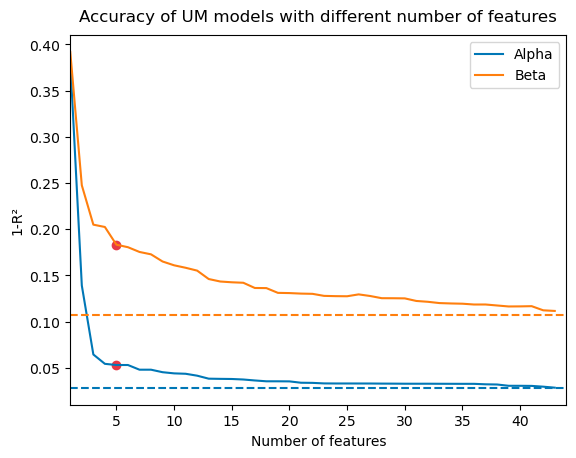

In [ ]:

xx = np.arange(1,len(UM_res_alpha )+1)
plt.plot(xx, 1- UM_res_alpha, color=b)
plt.plot(xx, 1- UM_res_beta, color=o)
plt.legend(["Alpha", "Beta"])
plt.xlabel("Number of features")
plt.title("Accuracy of UM models with different number of features",pad=10)
plt.ylabel("1-R²")
ax = plt.gca()
ax.axhline(y=1-UM_r2_alpha_all_features, color=b, linestyle='--')
ax.axhline(y=1-UM_r2_beta_all_features, color=o, linestyle='--')
# ['S02' 'S29' 'H3K4me3'] bei alpha
# ['H3K4me3' 'H3K56ac' 'Input'] bei beta
# add single red point at (7, UM_res_alpha[6])
plt.scatter(5, 1-UM_res_alpha[4], color=r)
plt.scatter(5, 1-UM_res_beta[4], color=r)
# set x range from 1 to len(UM_res_alpha) +1
plt.xlim(1, len(UM_res_alpha)+1)

# make y axis log
# plt.yscale('log')




In [ ]:
important_X_alpha = X[['S29', 'H3K4Me1', 'H3K36Me3', 'H3K56Ac', 'cg_density']]
important_X_beta = X[['S29','H3K4Me1', 'H3K36Me3', 'H3K56Ac', 'S32']]

reg = LinearRegression()
alpha_coeff = reg.fit(important_X_alpha, y).coef_
beta_coeff = reg.fit(important_X_beta, w).coef_

print(alpha_coeff)
print(beta_coeff)

[-2.1064355e-07  3.8644181e-09 -4.7006044e-09  3.3782872e-09
 -1.8119435e-09]
[-1.0792660e-05  2.9393516e-07 -5.1096526e-07  4.1880151e-07
 -7.7881632e-05]


# Model for teM Genes

                            OLS Regression Results                            
Dep. Variable:                   beta   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.9103
Date:                Mon, 08 Jan 2024   Prob (F-statistic):              0.623
Time:                        11:41:15   Log-Likelihood:                 765.27
No. Observations:                  99   AIC:                            -1443.
Df Residuals:                      55   BIC:                            -1328.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.227e-05      0.001     -0.037      0.9

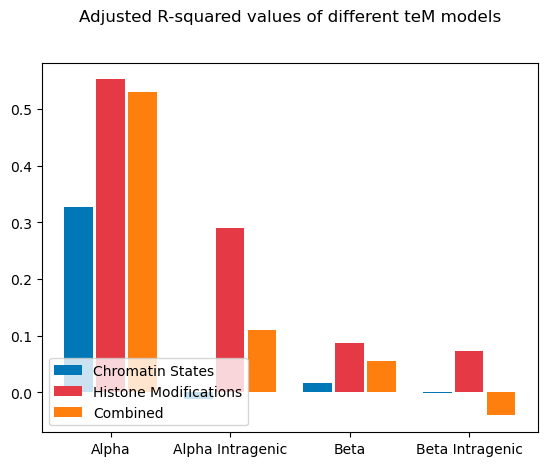

In [ ]:
teM_data = cs_teM.hstack(hist_mods_teM)
teM_data = teM_data.with_columns(alpha=teM_alpha)
teM_data = teM_data.with_columns(beta=teM_beta)
teM_data_intragenic = teM_data[100:199]


teM_alpha_formula_cs = "alpha ~ " + " + ".join([s for s in teM_data.columns if s != "alpha" and s != "beta" and "S" in s])
teM_beta_formula_cs = "beta ~ " + " + ".join([s for s in teM_data.columns if s != "alpha" and s != "beta" and "S" in s])
teM_alpha_formula_hist_mods = "alpha ~ " + " + ".join([s for s in teM_data.columns if s != "alpha" and s != "beta" and "S" not in s])
teM_beta_formula_hist_mods = "beta ~ " + " + ".join([s for s in teM_data.columns if s != "alpha" and s != "beta" and "S" not in s])
teM_alpha_formula_combined = "alpha ~ " + " + ".join([s for s in teM_data.columns if s != "alpha" and s != "beta"])
teM_beta_formula_combined = "beta ~ " + " + ".join([s for s in teM_data.columns if s != "alpha" and s != "beta"])

teM_model_alpha_cs = ols(teM_alpha_formula_cs, teM_data).fit()
teM_model_beta_cs = ols(teM_beta_formula_cs, teM_data).fit()
teM_model_alpha_hist_mods = ols(teM_alpha_formula_hist_mods, teM_data).fit()
teM_model_beta_hist_mods = ols(teM_beta_formula_hist_mods, teM_data).fit()
teM_model_alpha_combined = ols(teM_alpha_formula_combined, teM_data).fit()
teM_model_beta_combined = ols(teM_beta_formula_combined, teM_data).fit()

teM_model_alpha_cs_intragenic = ols(teM_alpha_formula_cs, teM_data_intragenic).fit()
teM_model_beta_cs_intragenic = ols(teM_beta_formula_cs, teM_data_intragenic).fit()
teM_model_alpha_hist_mods_intragenic = ols(teM_alpha_formula_hist_mods, teM_data_intragenic).fit()
teM_model_beta_hist_mods_intragenic = ols(teM_beta_formula_hist_mods, teM_data_intragenic).fit()
teM_model_alpha_combined_intragenic = ols(teM_alpha_formula_combined, teM_data_intragenic).fit()
teM_model_beta_combined_intragenic = ols(teM_beta_formula_combined, teM_data_intragenic).fit()
print(teM_model_beta_combined_intragenic.summary())

teM_data_grouped = {
    "Chromatin States": [teM_model_alpha_cs.rsquared_adj, teM_model_alpha_cs_intragenic.rsquared_adj, teM_model_beta_cs.rsquared_adj, teM_model_beta_cs_intragenic.rsquared_adj],
    "Histone Modifications": [teM_model_alpha_hist_mods.rsquared_adj, teM_model_alpha_hist_mods_intragenic.rsquared_adj, teM_model_beta_hist_mods.rsquared_adj, teM_model_beta_hist_mods_intragenic.rsquared_adj],
    "Combined": [teM_model_alpha_combined.rsquared_adj, teM_model_alpha_combined_intragenic.rsquared_adj, teM_model_beta_combined.rsquared_adj, teM_model_beta_combined_intragenic.rsquared_adj]
}

fig, ax = plt.subplots()
bar_plot(ax, teM_data_grouped, total_width=.8, single_width=.9, colors=[b,r,o])
plt.title("Adjusted R-squared values of different teM models",pad=30)
plt.xticks(range(4), ["Alpha", "Alpha Intragenic", "Beta", "Beta Intragenic"])
plt.show()



In [ ]:
gene_lengths = pl.DataFrame({"type": ["gbM", "UM", "teM"], "count": [5314, 12684, 974], "gene_length": [3994.8964998118176, 1683.1744717754652, 1713.416837782341], "combined_length": [21228880, 21349385, 1668868]})
display(gene_lengths)

shape: (3, 4)
┌──────┬───────┬─────────────┬─────────────────┐
│ type ┆ count ┆ gene_length ┆ combined_length │
│ ---  ┆ ---   ┆ ---         ┆ ---             │
│ str  ┆ i64   ┆ f64         ┆ i64             │
╞══════╪═══════╪═════════════╪═════════════════╡
│ gbM  ┆ 5314  ┆ 3994.8965   ┆ 21228880        │
│ UM   ┆ 12684 ┆ 1683.174472 ┆ 21349385        │
│ teM  ┆ 974   ┆ 1713.416838 ┆ 1668868         │
└──────┴───────┴─────────────┴─────────────────┘

Plotting Histone Mods

In [ ]:
dpi = 120


gbM = hist_mods_gbM
gbM = gbM.with_columns(CG_Density=cg_int)
gbM = gbM.rename({"CG_Density": "CG Density"})
UM = hist_mods_UM
UM = UM.with_columns(CG_Density=UM_cg_counts)
UM = UM.rename({"CG_Density": "CG Density"})
teM = hist_mods_teM
teM = teM.with_columns(CG_Density=teM_cg_counts)
teM = teM.rename({"CG_Density": "CG Density"})

# correct for avg gene length * gene count
gbM = gbM / gene_lengths.filter(pl.col("type") == "gbM")["combined_length"].item() 
UM = UM / gene_lengths.filter(pl.col("type") == "UM")["combined_length"].item() 
teM = teM / gene_lengths.filter(pl.col("type") == "teM")["combined_length"].item()

gbM = gbM.with_columns(Alpha=alpha)
gbM = gbM.with_columns(Beta=beta)
UM = UM.with_columns(Alpha=UM_alpha)
UM = UM.with_columns(Beta=UM_alpha)
teM = teM.with_columns(Alpha=teM_alpha)
teM = teM.with_columns(Beta=teM_beta)


gbM = gbM.select(sorted(gbM.columns))
UM = UM.select(sorted(UM.columns))
teM = teM.select(sorted(teM.columns))

fig, axes = plt.subplots(gbM.width // 2, 2, sharex=True, figsize=(14,20)) 

r = "#e63946"
b = "#0077b6"

def format_tick(x, pos): 
        if x < 0: 
            return f'{(x //250):.0f} Kb'
        elif x <= 1000:
            return f'{(x/10):.0f}%'
        else:
            return f'{((x -1000) // 250):.0f} Kb'

ax1 = axes[0]
for ax in ax1:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
    ax.annotate("TSS", xy=(0,0), xytext=(-55, 0.002),  color='C7', fontsize=12)
    ax.annotate("TTS", xy=(100,0), xytext=(945, 0.002),  color='C7', fontsize=12)

for (ax, (state, gbM_windows), (_, UM_windows), (_, teM_windows)) in zip(axes.reshape(-1), gbM.to_dict().items(), UM.to_dict().items(), teM.to_dict().items()):
    ax.plot(x, np.array(list(teM_windows)), o, alpha=0.5)
    ax.plot(x, np.array(list(UM_windows)), r)
    ax.plot(x, np.array(list(gbM_windows)), b)

    if "H" in state:
         ax.set_ylim(0, 1)

    ax.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
    ax.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
    
    ax.set_ylabel(f'{state}')
    ax.spines['top'].set_visible(False)

for ax in ax1:
     ax.legend(['teM', 'UM', "gbM"], loc='upper right')

    

fig.align_ylabels(axes)
fig.tight_layout(pad=0)
# plt.savefig("cs_combined.jpg", dpi=240, bbox_inches="tight", pad_inches = .5)
plt.show()

Plot chromatine states

In [ ]:
dpi = 120


gbM = cs_gbM
UM = cs_UM
teM = cs_teM

# correct for avg gene length * gene count
gbM = gbM / gene_lengths.filter(pl.col("type") == "gbM")["combined_length"].item() 
UM = UM / gene_lengths.filter(pl.col("type") == "UM")["combined_length"].item() 
teM = teM / gene_lengths.filter(pl.col("type") == "teM")["combined_length"].item()

gbM = gbM.with_columns(Alpha=alpha)
gbM = gbM.with_columns(Beta=beta)
UM = UM.with_columns(Alpha=UM_alpha)
UM = UM.with_columns(Beta=UM_alpha)
teM = teM.with_columns(Alpha=teM_alpha)
teM = teM.with_columns(Beta=teM_beta)


gbM = gbM.select(sorted(gbM.columns))
UM = UM.select(sorted(UM.columns))
teM = teM.select(sorted(teM.columns))



fig, axes = plt.subplots(gbM.width // 2, 2, sharex=True, figsize=(14,20)) 

r = "#e63946"
b = "#0077b6"

def format_tick(x, pos): 
        if x < 0: 
            return f'{(x //250):.0f} Kb'
        elif x <= 1000:
            return f'{(x/10):.0f}%'
        else:
            return f'{((x -1000) // 250):.0f} Kb'

ax1 = axes[0]
for ax in ax1:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
    ax.annotate("TSS", xy=(0,0), xytext=(-55, 0.002),  color='C7', fontsize=12)
    ax.annotate("TTS", xy=(100,0), xytext=(945, 0.002),  color='C7', fontsize=12)

for (ax, (state, gbM_windows), (_, UM_windows), (_, teM_windows)) in zip(axes.reshape(-1), gbM.to_dict().items(), UM.to_dict().items(), teM.to_dict().items()):
    ax.plot(x, np.array(list(teM_windows)), o, alpha=0.5)
    ax.plot(x, np.array(list(UM_windows)), r)
    ax.plot(x, np.array(list(gbM_windows)), b)

    if "H" in state:
         ax.set_ylim(0, 125000)

    ax.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
    ax.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
    
    ax.set_ylabel(f'{state}')
    ax.spines['top'].set_visible(False)

for ax in ax1:
     ax.legend(['teM', 'UM', "gbM"], loc='upper right')

    

fig.align_ylabels(axes)
fig.tight_layout(pad=0)
# plt.savefig("cs_combined.jpg", dpi=240, bbox_inches="tight", pad_inches = .5)
plt.show()

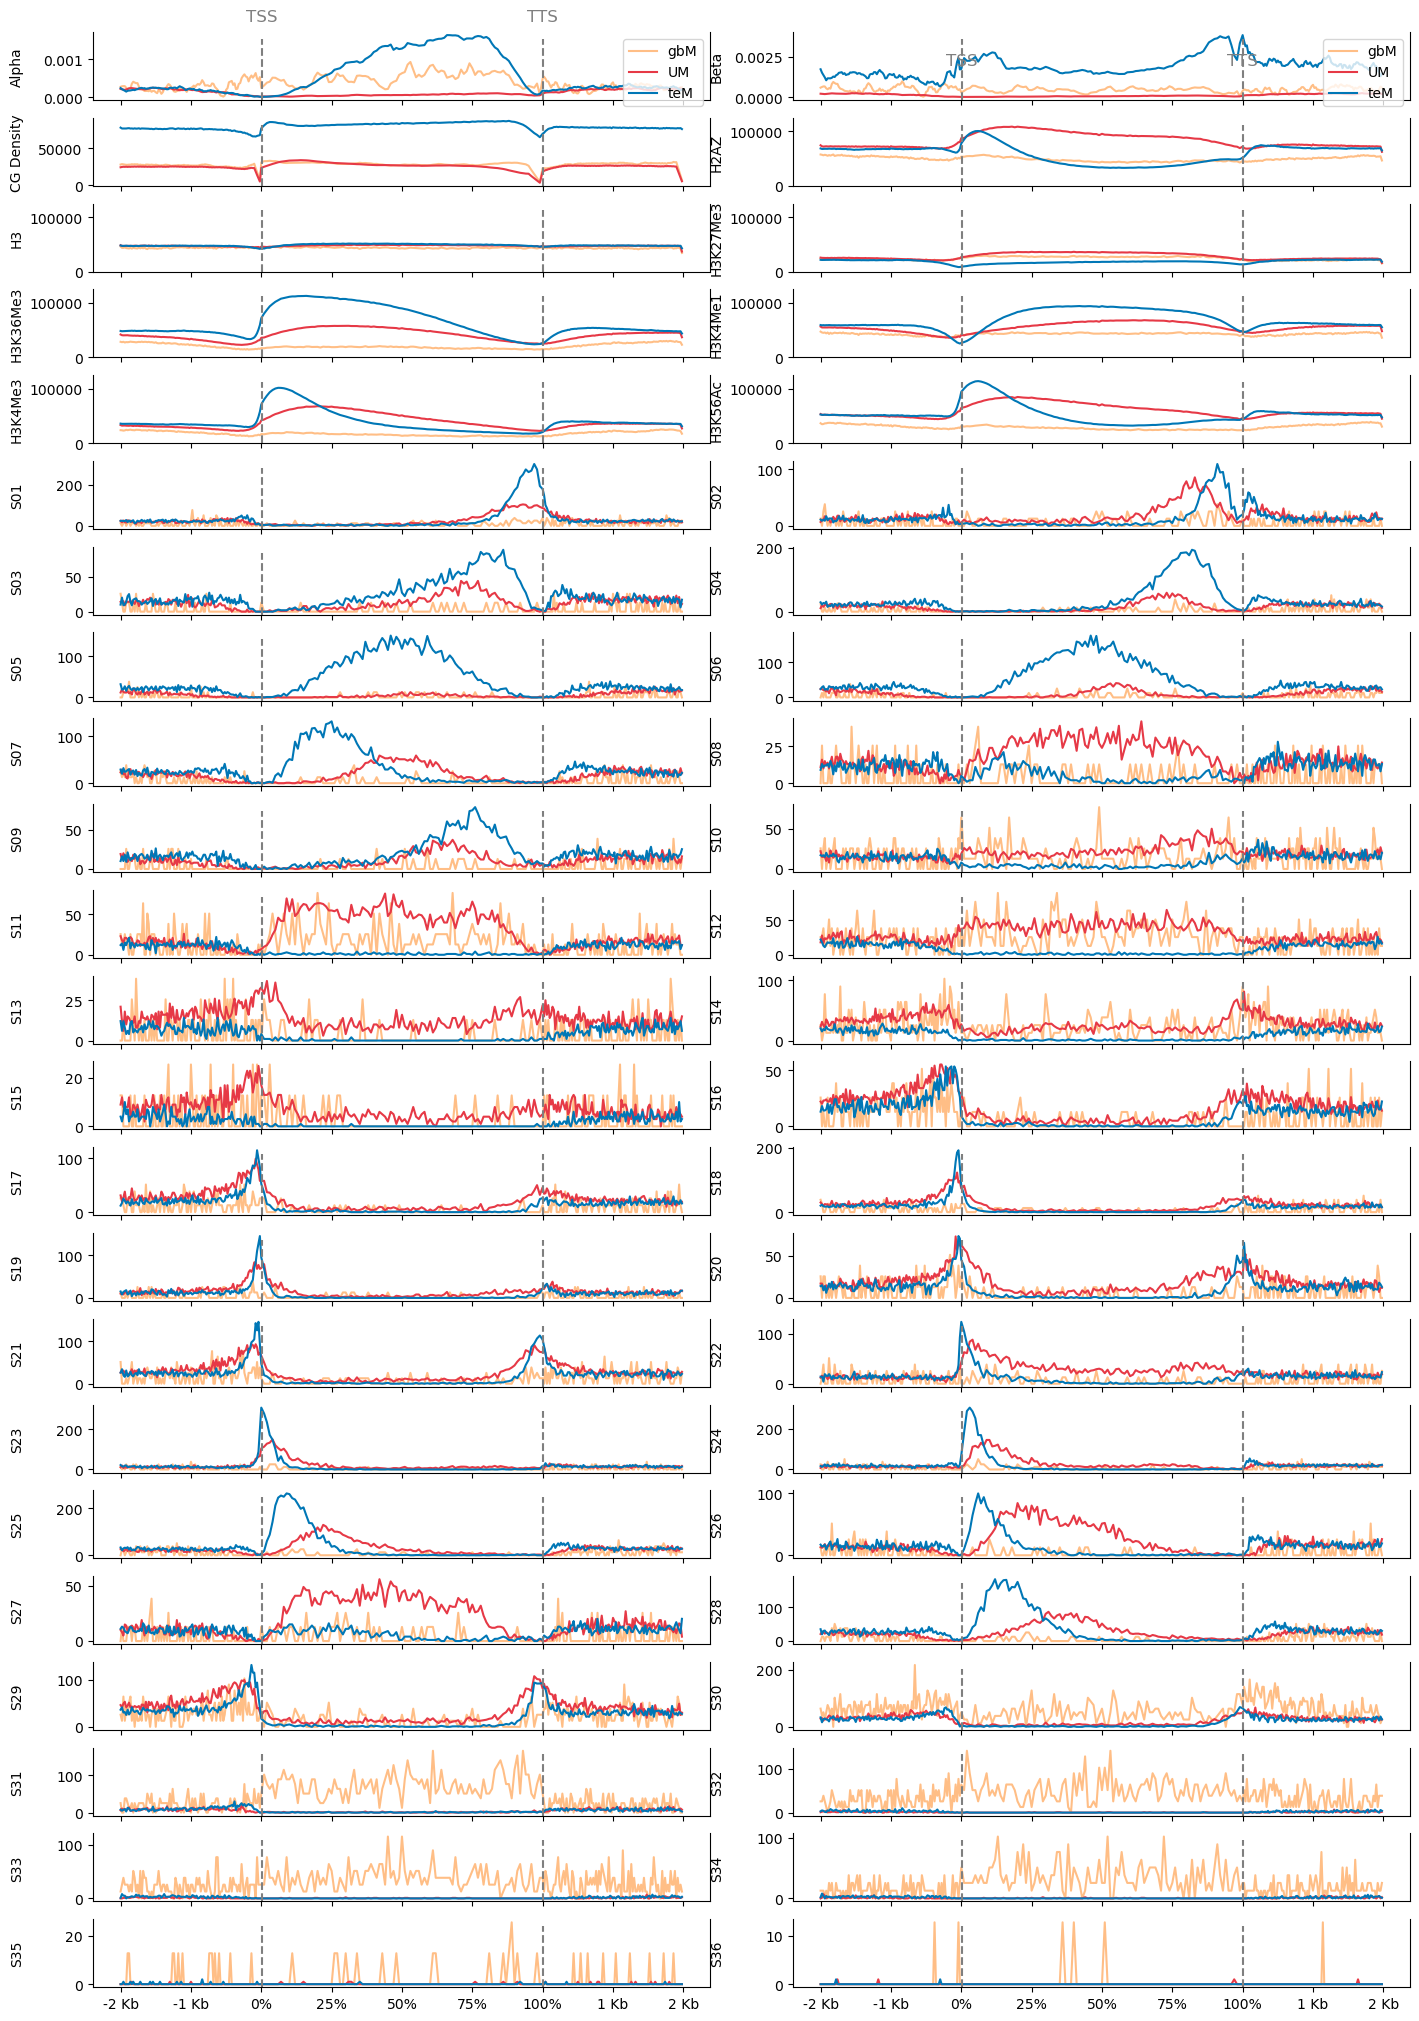

In [ ]:
dpi = 120


gbM = cs_gbM.hstack(hist_mods_gbM)
gbM = gbM.with_columns(CG_Density=cg_int)
gbM = gbM.rename({"CG_Density": "CG Density"})
UM = cs_UM.hstack(hist_mods_UM)
UM = UM.with_columns(CG_Density=UM_cg_counts)
UM = UM.rename({"CG_Density": "CG Density"})
teM = cs_teM.hstack(hist_mods_teM)
teM = teM.with_columns(CG_Density=teM_cg_counts)
teM = teM.rename({"CG_Density": "CG Density"})

# correct for avg gene length * gene count
gbM = gbM / gene_lengths.filter(pl.col("type") == "gbM")["combined_length"].item() 
UM = UM / gene_lengths.filter(pl.col("type") == "UM")["combined_length"].item() 
teM = teM / gene_lengths.filter(pl.col("type") == "teM")["combined_length"].item()

gbM = gbM.with_columns(Alpha=alpha)
gbM = gbM.with_columns(Beta=beta)
UM = UM.with_columns(Alpha=UM_alpha)
UM = UM.with_columns(Beta=UM_alpha)
teM = teM.with_columns(Alpha=teM_alpha)
teM = teM.with_columns(Beta=teM_beta)


gbM = gbM.select(sorted(gbM.columns))
UM = UM.select(sorted(UM.columns))
teM = teM.select(sorted(teM.columns))



fig, axes = plt.subplots(gbM.width // 2, 2, sharex=True, figsize=(14,20)) 

r = "#e63946"
b = "#0077b6"

def format_tick(x, pos): 
        if x < 0: 
            return f'{(x //250):.0f} Kb'
        elif x <= 1000:
            return f'{(x/10):.0f}%'
        else:
            return f'{((x -1000) // 250):.0f} Kb'

ax1 = axes[0]
for ax in ax1:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
    ax.annotate("TSS", xy=(0,0), xytext=(-55, 0.002),  color='C7', fontsize=12)
    ax.annotate("TTS", xy=(100,0), xytext=(945, 0.002),  color='C7', fontsize=12)

for (ax, (state, gbM_windows), (_, UM_windows), (_, teM_windows)) in zip(axes.reshape(-1), gbM.to_dict().items(), UM.to_dict().items(), teM.to_dict().items()):
    ax.plot(x, np.array(list(teM_windows)), o, alpha=0.5)
    ax.plot(x, np.array(list(UM_windows)), r)
    ax.plot(x, np.array(list(gbM_windows)), b)

    if "H" in state:
         ax.set_ylim(0, 125000)

    ax.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
    ax.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
    
    ax.set_ylabel(f'{state}')
    ax.spines['top'].set_visible(False)

for ax in ax1:
     ax.legend(['teM', 'UM', "gbM"], loc='upper right')

    

fig.align_ylabels(axes)
fig.tight_layout(pad=0)
plt.savefig("cs_combined.jpg", dpi=240, bbox_inches="tight", pad_inches = .5)
plt.show()

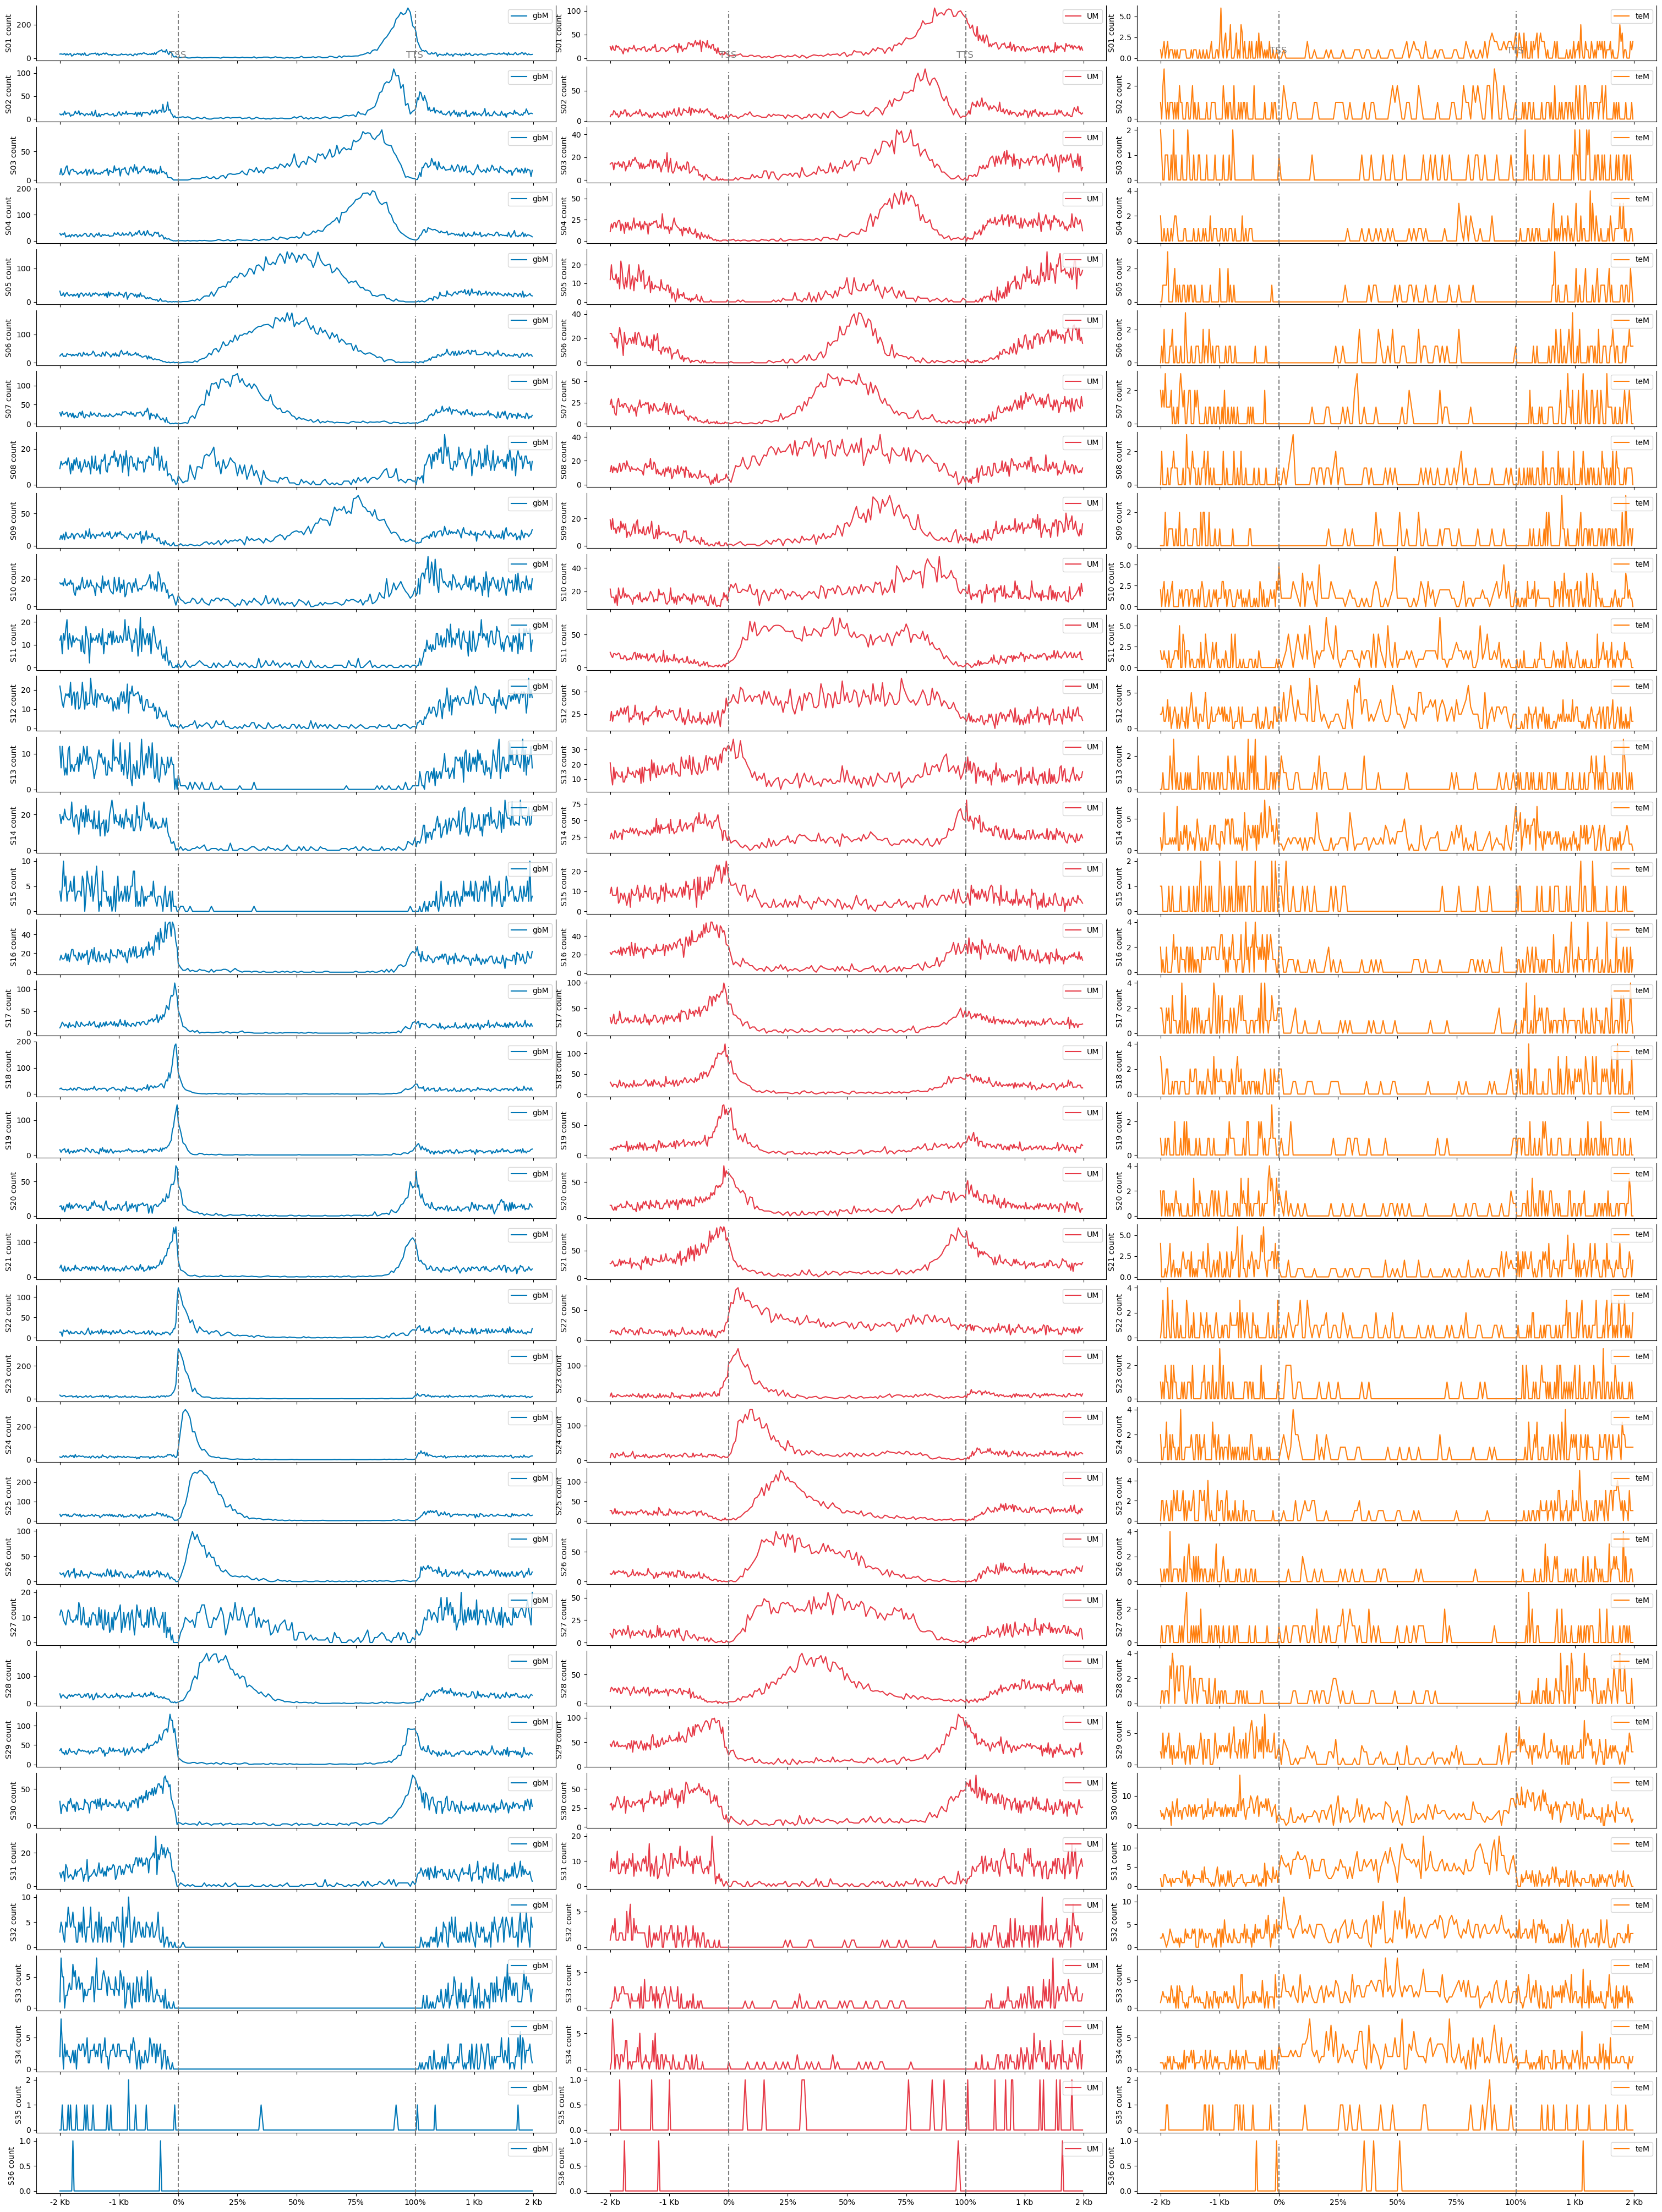

In [ ]:
dpi = 120

fig, axes = plt.subplots(cs_gbM.width,3 ,sharex=True, figsize=(30,40)) 

r = "#e63946"
b = "#0077b6"
o = "C1"


ax1 = axes[0]
for subaxis in ax1: 
    subaxis.xaxis.set_major_formatter(plt.FuncFormatter(format_tick))
    subaxis.annotate("TSS", xy=(0,0), xytext=(-40, 0.55),  color='C7', fontsize=12)
    subaxis.annotate("TTS", xy=(100,0), xytext=(962, 0.55),  color='C7', fontsize=12)

for ((ax1, ax2, ax3), (state, gbM_windows), (_, UM_windows), (_, teM_windows)) in zip(axes, cs_gbM.to_dict().items(), cs_UM.to_dict().items(), cs_teM.to_dict().items()):
    ax1.plot(x, np.array(list(gbM_windows)), b)
    ax2.plot(x, np.array(list(UM_windows)), r)
    ax3.plot(x, np.array(list(teM_windows)), o)

    def format_tick(x, pos): 
        if x < 0: 
            return f'{(x //250):.0f} Kb'
        elif x <= 1000:
            return f'{(x/10):.0f}%'
        else:
            return f'{((x -1000) // 250):.0f} Kb'
        
    ax1.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
    ax1.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
    ax1.legend(['gbM'], loc='upper right')
    ax1.set_ylabel(f'{state} count')
    ax1.spines['top'].set_visible(False)

    ax2.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
    ax2.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
    ax2.legend([ "UM"], loc='upper right')
    ax2.set_ylabel(f'{state} count')
    ax2.spines['top'].set_visible(False)

    ax3.axvline(x=1,ymax=0.9, color='C7', linestyle='--')
    ax3.axvline(x=1001, ymax=0.9,color='C7', linestyle='--')
    ax3.legend([ "teM"], loc='upper right')
    ax3.set_ylabel(f'{state} count')
    ax3.spines['top'].set_visible(False)


fig.tight_layout(pad=0)
plt.savefig("cs.jpg", dpi=200, bbox_inches="tight", pad_inches = 1)
plt.show()

# Fig. 3D

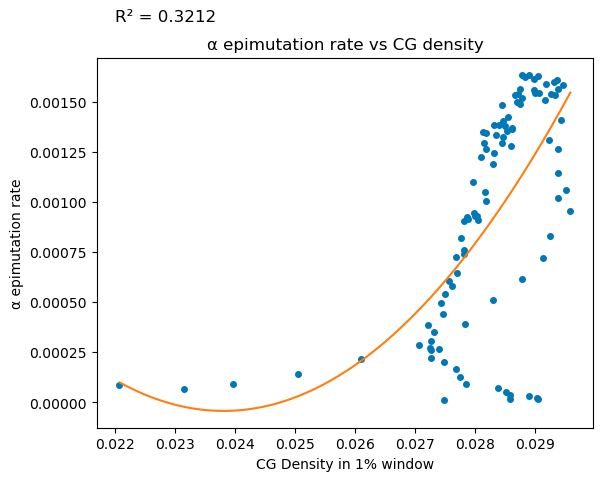

In [ ]:
intragenic_cg_density = cg_density[101:200] 
intragenic_alpha = alpha[101:200]


z = list(zip(intragenic_cg_density, intragenic_alpha))
z = np.array(z,dtype=[('cg_density', float), ('alpha', float)])
s = np.sort(z, order='cg_density' )
cg_dens,alph = zip(*s)



p = np.polyfit(intragenic_cg_density, intragenic_alpha, 2)
x = np.linspace(min(intragenic_cg_density), max(intragenic_cg_density), num=100)


plt.plot(cg_dens, alph, 'o', color=b, markersize=4)
plt.title("α epimutation rate vs CG density")
plt.plot(x, np.poly1d(p)(x), color='C1')
plt.text(0.022, 0.0019, f"R² = 0.3212", fontsize=12)
plt.xlabel("CG Density in 1% window")
plt.ylabel("α epimutation rate")
plt.savefig("3_D.png", dpi=450, ) # TODO: alpha label not readable
plt.show()


## Fig. 3E 

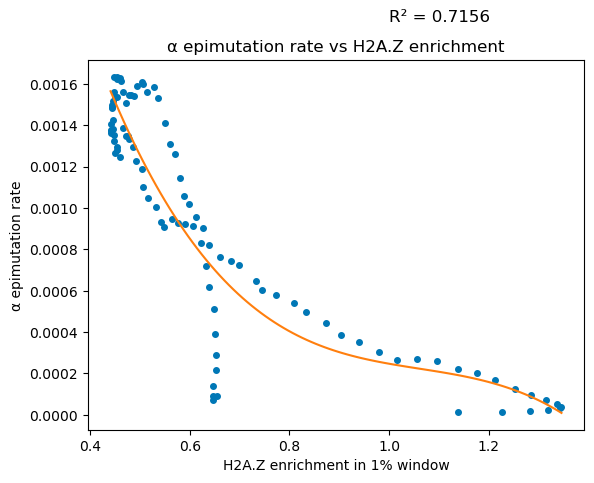

In [ ]:
intragenic_h2az = h2az[101:200]
intragenic_alpha = alpha[101:200]


z = list(zip(intragenic_h2az, intragenic_alpha))
z = np.array(z,dtype=[('cg_density', float), ('alpha', float)])
s = np.sort(z, order='cg_density' )
cg_dens,alph = zip(*s)



p = np.polyfit(intragenic_h2az, intragenic_alpha, 3)
x = np.linspace(min(intragenic_h2az), max(intragenic_h2az), num=100)


plt.plot(cg_dens, alph, 'o', color=b, markersize=4)
plt.title("α epimutation rate vs H2A.Z enrichment")
plt.plot(x, np.poly1d(p)(x), color='C1')
plt.text(1, 0.0019, f"R² = 0.7156", fontsize=12)
plt.xlabel("H2A.Z enrichment in 1% window")
plt.ylabel("α epimutation rate")
plt.savefig("3_E.png", dpi=450) # TODO: alpha label not readable
plt.show()

# Fig. 1C 

Column Chart for Steady State

/tmp/ipykernel_18543/1567519545.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(gens)


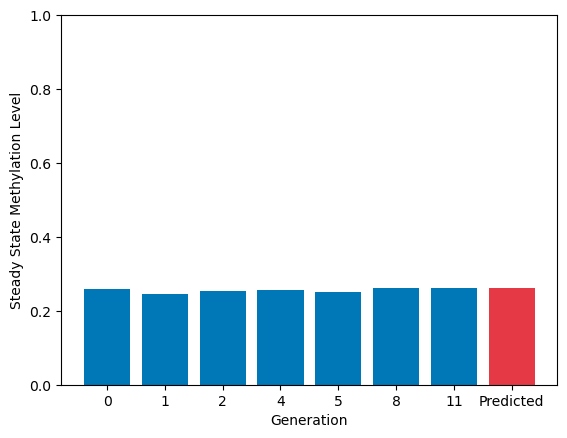

In [ ]:

gens = ['', 0,1,2,4,5,8,11, "Predicted"]

# Create a figure and axes objects
fig, ax = plt.subplots()

# Create a list of colors for the columns
colors = [b] * 7 + [r] 

# Create the bar chart with custom colors
ax.bar(range(8), np.array(meth_lvl, dtype=np.float32), color=colors)

# Set the x-axis tick labels
ax.set_xticklabels(gens)
ax.set_ybound(0.0, 1.0)

# Set the title and axis labels
ax.set_xlabel('Generation')
ax.set_ylabel('Steady State Methylation Level')

# Show the plot
plt.savefig("1C.png", dpi=450)
plt.show()



## Fig. 1B

Divergence over Time

The optained Z-Score 16.00161281731142 leads to a p-value of 1.0000202970953328e-56, which rejects the Null-Hypothesis


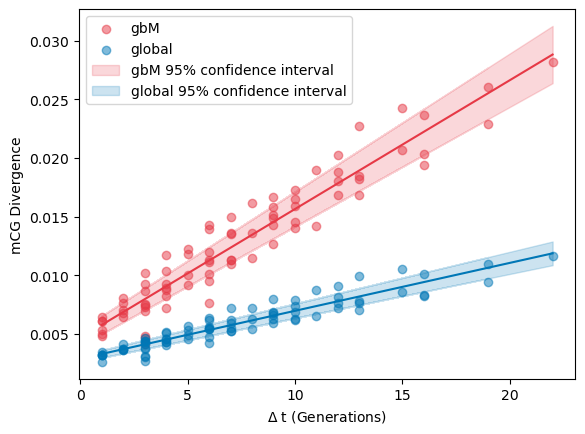

In [ ]:
from scipy import stats

delta_t = D_dt[:,D_dt_headers.index("delta_t")]
D_gbM = D_dt[:,D_dt_headers.index("gbM")]
D_global = D_dt[:,D_dt_headers.index("all")]


fit_gbM = np.poly1d(np.polyfit(delta_t, D_gbM, 1))
fit_global = np.poly1d(np.polyfit(delta_t, D_global, 1))

lr_gbM = stats.linregress(delta_t, D_gbM)
lr_global = stats.linregress(delta_t, D_global)

x = np.linspace(min(delta_t), max(delta_t), num=100)

# Hypothesis test
# Nullhypthesis: slope (aka mutation rate) is the same between the two regions
# Alternative: the slope is different
# alpha < 0.05
# Using the Z-Test:  Clogg, C. C., Petkova, E., & Haritou, A. (1995). Statistical methods for comparing regression coefficients between models. American Journal of Sociology, 100(5), 1261–1293. https://doi.org/10.1086/230638
z = lambda b1, b2, stderr_b1, stderr_b2: (b1 - b2) / np.sqrt(stderr_b1**2 + stderr_b2**2)

Z = z(lr_gbM.slope, lr_global.slope, lr_gbM.stderr, lr_global.stderr)
p = stats.norm.pdf(Z)

print(f"The optained Z-Score {Z} leads to a p-value of {p}, which rejects the Null-Hypothesis")





# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
ts = abs(stats.t.ppf(0.05/2, len(D_gbM)-2))


plt.scatter(delta_t, D_gbM, color=r, alpha=0.5, label="gbM")
plt.scatter(delta_t, D_global, color=b, alpha= 0.5, label = "global")
plt.fill_between(delta_t, delta_t * (lr_gbM.slope -  ts * lr_gbM.stderr) + lr_gbM.intercept - ts*lr_gbM.intercept_stderr, delta_t * (lr_gbM.slope + ts * lr_gbM.stderr) + lr_gbM.intercept  + ts*lr_gbM.intercept_stderr, color=r, alpha=0.2, label="gbM 95% confidence interval")
plt.fill_between(delta_t, delta_t * (lr_global.slope -  ts * lr_global.stderr) + lr_global.intercept - ts*lr_global.intercept_stderr, delta_t * (lr_global.slope + ts * lr_global.stderr) + lr_global.intercept  + ts*lr_global.intercept_stderr, color=b, alpha=0.2, label="global 95% confidence interval")

plt.legend()
plt.ylabel("mCG Divergence")
plt.xlabel("$\Delta$ t (Generations)")
plt.plot(x, fit_gbM(x), color=r)
plt.plot(x, fit_global(x), color=b)
plt.savefig("1D.png", dpi=450)
plt.show()


# Plotting genome-wide epimutation rate predictions

In [ ]:
labels_chr_1 = pl.read_parquet("/mnt/fast/epigenomics/conschti/labels/1.parquet")
i = np.arange(1, labels_chr_1.height +1)
labels_chr_1 = labels_chr_1.with_columns(i=i).set_sorted("i")
averaged = labels_chr_1.group_by_dynamic(index_column="i", period="10000i", every="5000i").agg(pl.mean("alpha"), pl.mean("beta"), pl.mean("std_st"))

# plt.plot(averaged["i"], averaged["alpha"], color=b)
# plt.plot(averaged["i"], averaged["beta"], color=r)
# plt.plot(averaged["i"], averaged["std_st"], color=o)
# plt.legend(["Alpha", "Beta", "Steady State Methylation Level"])
# plt.show()
labels_chr_1 = labels_chr_1.filter(pl.col("sequence") == 2)
plt.plot(labels_chr_1[:100000]["i"], labels_chr_1[:100000]["steady_state"], color=b)
# plt.plot(labels_chr_1[:100000]["i"], labels_chr_1[:100000]["beta"], color=r)
plt.ylim(0, 0.002)


ColumnNotFoundError: steady_state